In [2]:
!pip install gdown
!gdown --id 1j4phfJPn3gj6QhgrFy6FZIEvny-8htzB

^C
ERROR: Operation cancelled by user
/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1j4phfJPn3gj6QhgrFy6FZIEvny-8htzB
From (redirected): https://drive.google.com/uc?id=1j4phfJPn3gj6QhgrFy6FZIEvny-8htzB&confirm=t&uuid=31327843-3f00-425b-8535-dac4f743b04d
To: /kaggle/working/CASIA-B-pkl.zip
100%|████████████████████████████████████████| 358M/358M [00:13<00:00, 26.7MB/s]


In [ ]:
!unzip /kaggle/working/CASIA-B-pkl
!git clone https://github.com/Ankit3002/OpenGait.git
!mv OpenGait/* /kaggle/working
!rm -rf OpenGait

In [ ]:
# https://drive.google.com/file/d/1IurwhECWDjkcuD1XwJTB2DBIsYeavZtR/view?usp=sharing
# download the model checkpoint from here... ( Most Effiecient Encoder Trained with Triplet and Cross Entropy Loss)
!gdown --id 1IurwhECWDjkcuD1XwJTB2DBIsYeavZtR
# Drive link for --> https://drive.google.com/file/d/10L-MZcV4cR-cxrNGgSyBM9R-r1N-jTnu/view?usp=sharing
# Downloading the Most Efficent model Trained till now ...
!gdown --id 10L-MZcV4cR-cxrNGgSyBM9R-r1N-jTnu

In [15]:
import os
import json
import os.path as osp
import torch.utils.data as tordata

import os
import pickle
import os.path as osp
import torch.utils.data as tordata
import json
# from utils import get_msg_mgr


class DataSetClass(tordata.Dataset):
    def __init__(self, data_cfg, training):
        """
            seqs_info: the list with each element indicating 
                            a certain gait sequence presented as [label, type, view, paths];
        """
        self.__dataset_parser(data_cfg, training)
#         self.cache = data_cfg['cache']
        self.label_list = [seq_info[0] for seq_info in self.seqs_info]
        self.types_list = [seq_info[1] for seq_info in self.seqs_info]
        self.views_list = [seq_info[2] for seq_info in self.seqs_info]

        self.label_set = sorted(list(set(self.label_list)))
        self.types_set = sorted(list(set(self.types_list)))
        self.views_set = sorted(list(set(self.views_list)))
        self.seqs_data = [None] * len(self)
        self.indices_dict = {label: [] for label in self.label_set}
        for i, seq_info in enumerate(self.seqs_info):
            self.indices_dict[seq_info[0]].append(i)
#         if self.cache:
#             self.__load_all_data()

    def __len__(self):
        return len(self.seqs_info)

    def __loader__(self, paths):
        paths = sorted(paths)
        data_list = []
        for pth in paths:
            if pth.endswith('.pkl'):
                with open(pth, 'rb') as f:
                    _ = pickle.load(f)
                f.close()
            else:
                raise ValueError('- Loader - just support .pkl !!!')
            data_list.append(_)
        for idx, data in enumerate(data_list):
            if len(data) != len(data_list[0]):
                raise ValueError(
                    'Each input data({}) should have the same length.'.format(paths[idx]))
            if len(data) == 0:
                raise ValueError(
                    'Each input data({}) should have at least one element.'.format(paths[idx]))
        return data_list

    def __getitem__(self, idx):
#         if not self.cache:
        data_list = self.__loader__(self.seqs_info[idx][-1])
        if self.seqs_data[idx] is None:
            data_list = self.__loader__(self.seqs_info[idx][-1])
            self.seqs_data[idx] = data_list
        else:
            data_list = self.seqs_data[idx]
        seq_info = self.seqs_info[idx]
        return data_list, seq_info

    def __load_all_data(self):
        for idx in range(len(self)):
            self.__getitem__(idx)

    def __dataset_parser(self, data_config, training):
        dataset_root = data_config['dataset_root']
        try:
            data_in_use = data_config['data_in_use']  # [n], true or false
        except:
            data_in_use = None

        with open(data_config['dataset_partition'], "rb") as f:
            partition = json.load(f)
        train_set = partition["TRAIN_SET"]
        test_set = partition["TEST_SET"]
        label_list = os.listdir(dataset_root)
        train_set = [label for label in train_set if label in label_list]
        test_set = [label for label in test_set if label in label_list]
        miss_pids = [label for label in label_list if label not in (
            train_set + test_set)]

        def get_seqs_info_list(label_set):
            seqs_info_list = []
            for lab in label_set:
                for typ in sorted(os.listdir(osp.join(dataset_root, lab))):
                    for vie in sorted(os.listdir(osp.join(dataset_root, lab, typ))):
                        seq_info = [lab, typ, vie]
                        seq_path = osp.join(dataset_root, *seq_info)
                        seq_dirs = sorted(os.listdir(seq_path))
                        if seq_dirs != []:
                            seq_dirs = [osp.join(seq_path, dir)
                                        for dir in seq_dirs]
                            if data_in_use is not None:
                                seq_dirs = [dir for dir, use_bl in zip(
                                    seq_dirs, data_in_use) if use_bl]
                            seqs_info_list.append([*seq_info, seq_dirs])
#                         else:
#                             msg_mgr.log_debug(
#                                 'Find no .pkl file in %s-%s-%s.' % (lab, typ, vie))
            return seqs_info_list

        self.seqs_info = get_seqs_info_list(
            train_set) if training else get_seqs_info_list(test_set)


# Creating the data_cfg dictionary
data_cfg = {
    "dataset_name": "CASIA-B",
    "dataset_root": "/kaggle/working/CASIA-B-pkl",
    "dataset_partition": "/kaggle/working/datasets/CASIA-B/CASIA-B.json",
    "num_workers": 1,
    "remove_no_gallery": False,
    "test_dataset_name": "CASIA-B"
}

training = True  # Boolean always in the code for checking that we are training or not
# Creating the dataset object and data loaders
dataset = DataSetClass(data_cfg, training)

In [16]:
import math
import random
import numpy as np
# from utils import get_msg_mgr


class CollateFn(object):
    def __init__(self, label_set, sample_config):
        self.label_set = label_set
        sample_type = sample_config['sample_type']
        sample_type = sample_type.split('_')
        self.sampler = sample_type[0]
        self.ordered = sample_type[1]
        if self.sampler not in ['fixed', 'unfixed', 'all']:
            raise ValueError
        if self.ordered not in ['ordered', 'unordered']:
            raise ValueError
        self.ordered = sample_type[1] == 'ordered'

        # fixed cases
        if self.sampler == 'fixed':
            self.frames_num_fixed = sample_config['frames_num_fixed']

        # unfixed cases
        if self.sampler == 'unfixed':
            self.frames_num_max = sample_config['frames_num_max']
            self.frames_num_min = sample_config['frames_num_min']

        if self.sampler != 'all' and self.ordered:
            self.frames_skip_num = sample_config['frames_skip_num']

        self.frames_all_limit = -1
        if self.sampler == 'all' and 'frames_all_limit' in sample_config:
            self.frames_all_limit = sample_config['frames_all_limit']

    def __call__(self, batch):
        batch_size = len(batch)
        # currently, the functionality of feature_num is not fully supported yet, it refers to 1 now. We are supposed to make our framework support multiple source of input data, such as silhouette, or skeleton.
        feature_num = len(batch[0][0])
        seqs_batch, labs_batch, typs_batch, vies_batch = [], [], [], []

        for bt in batch:
            seqs_batch.append(bt[0])
            labs_batch.append(self.label_set.index(bt[1][0]))
            typs_batch.append(bt[1][1])
            vies_batch.append(bt[1][2])

        global count
        count = 0

        def sample_frames(seqs):
            global count
            sampled_fras = [[] for i in range(feature_num)]
            seq_len = len(seqs[0])
            indices = list(range(seq_len))

            if self.sampler in ['fixed', 'unfixed']:
                if self.sampler == 'fixed':
                    frames_num = self.frames_num_fixed
                else:
                    frames_num = random.choice(
                        list(range(self.frames_num_min, self.frames_num_max+1)))

                if self.ordered:
                    fs_n = frames_num + self.frames_skip_num
                    if seq_len < fs_n:
                        it = math.ceil(fs_n / seq_len)
                        seq_len = seq_len * it
                        indices = indices * it

                    start = random.choice(list(range(0, seq_len - fs_n + 1)))
                    end = start + fs_n
                    idx_lst = list(range(seq_len))
                    idx_lst = idx_lst[start:end]
                    idx_lst = sorted(np.random.choice(
                        idx_lst, frames_num, replace=False))
                    indices = [indices[i] for i in idx_lst]
                else:
                    replace = seq_len < frames_num

#                     if seq_len == 0:
#                         get_msg_mgr().log_debug('Find no frames in the sequence %s-%s-%s.'
#                                                 % (str(labs_batch[count]), str(typs_batch[count]), str(vies_batch[count])))

                    count += 1
                    indices = np.random.choice(
                        indices, frames_num, replace=replace)

            for i in range(feature_num):
                for j in indices[:self.frames_all_limit] if self.frames_all_limit > -1 and len(indices) > self.frames_all_limit else indices:
                    sampled_fras[i].append(seqs[i][j])
            return sampled_fras

        # f: feature_num
        # b: batch_size
        # p: batch_size_per_gpu
        # g: gpus_num
        fras_batch = [sample_frames(seqs) for seqs in seqs_batch]  # [b, f]
        batch = [fras_batch, labs_batch, typs_batch, vies_batch, None]

        if self.sampler == "fixed":
            fras_batch = [[np.asarray(fras_batch[i][j]) for i in range(batch_size)]
                          for j in range(feature_num)]  # [f, b]
        else:
            seqL_batch = [[len(fras_batch[i][0])
                           for i in range(batch_size)]]  # [1, p]

            def my_cat(k): return np.concatenate(
                [fras_batch[i][k] for i in range(batch_size)], 0)
            fras_batch = [[my_cat(k)] for k in range(feature_num)]  # [f, g]

            batch[-1] = np.asarray(seqL_batch)

        batch[0] = fras_batch
        return batch


In [ ]:
import os
import torch
import torch.distributed as dist
import torch.utils.data as tordata
import inspect
import logging
import math
import random

# Example dataset (can be any dataset object as per your context)
# dataset = "example_dataset"  # Replace with your actual dataset object

# Define the sampler_cfg dictionary
sampler_cfg = {
    "batch_shuffle": True,
    "batch_size": [5, 10],  # Note the list for batch size
    "frames_num_fixed": 50,
    "frames_skip_num": 4,
    "sample_type": "fixed_ordered",  # This can be fixed_ordered, unfixed_ordered, or all_ordered
    "type": "TripletSampler"
}

def get_valid_args(obj, input_args, free_keys=[]):
    if inspect.isfunction(obj):
        expected_keys = inspect.getfullargspec(obj)[0]
    elif inspect.isclass(obj):
        expected_keys = inspect.getfullargspec(obj.__init__)[0]
    else:
        raise ValueError('Just support function and class object!')
    unexpect_keys = list()
    expected_args = {}
    for k, v in input_args.items():
        if k in expected_keys:
            expected_args[k] = v
        elif k in free_keys:
            pass
        else:
            unexpect_keys.append(k)
    if unexpect_keys != []:
        logging.info("Find Unexpected Args(%s) in the Configuration of - %s -" %
                     (', '.join(unexpect_keys), obj.__name__))
    return expected_args

def get_attr_from(sources, name):
    try:
        return getattr(sources[0], name)
    except:
        return get_attr_from(sources[1:], name) if len(sources) > 1 else getattr(sources[0], name)

# Manually set the environment variables for distributed training
os.environ['RANK'] = '0'
os.environ['WORLD_SIZE'] = '1'
os.environ['MASTER_ADDR'] = 'localhost'
os.environ['MASTER_PORT'] = '29500'

# Initialize the process group
dist.init_process_group(backend='nccl')  # Use 'gloo' or 'nccl' based on your configuration

class TripletSampler(tordata.sampler.Sampler):
    def __init__(self, dataset, batch_size, batch_shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        if len(self.batch_size) != 2:
            raise ValueError("batch_size should be (P x K) not {}".format(batch_size))
        self.batch_shuffle = batch_shuffle

        self.world_size = dist.get_world_size()
        if (self.batch_size[0] * self.batch_size[1]) % self.world_size != 0:
            raise ValueError("World size ({}) is not divisible by batch_size ({} x {})".format(
                self.world_size, batch_size[0], batch_size[1]))
        self.rank = dist.get_rank()

    def __iter__(self):
        while True:
            sample_indices = []
            pid_list = sync_random_sample_list(self.dataset.label_set, self.batch_size[0])

            for pid in pid_list:
                indices = self.dataset.indices_dict[pid]
                indices = sync_random_sample_list(indices, k=self.batch_size[1])
                sample_indices += indices

            if self.batch_shuffle:
                sample_indices = sync_random_sample_list(sample_indices, len(sample_indices))

            total_batch_size = self.batch_size[0] * self.batch_size[1]
            total_size = int(math.ceil(total_batch_size / self.world_size)) * self.world_size
            sample_indices += sample_indices[:(total_batch_size - len(sample_indices))]

            sample_indices = sample_indices[self.rank:total_size:self.world_size]
            yield sample_indices

    def __len__(self):
        return len(self.dataset)

# This function needs to be defined based on your actual requirements
def sync_random_sample_list(data_list, k):
    random.shuffle(data_list)
    return data_list[:k]

import opengait.data.sampler as Samplers

Sampler = get_attr_from([Samplers], sampler_cfg['type'])
valid_args = get_valid_args(Sampler, sampler_cfg, free_keys=['sample_type', 'type'])
sampler = Sampler(dataset, **valid_args)

print(sampler)
loader = tordata.DataLoader(
    dataset=dataset,
    batch_sampler=sampler,
    collate_fn=CollateFn(dataset.label_set, sampler_cfg),
    num_workers=data_cfg['num_workers'])


print(loader)


In [18]:
# losses are added over here...
import torch
import torch.nn.functional as F

# from .base import BaseLoss, gather_and_scale_wrapper
from ctypes import ArgumentError
import torch.nn as nn
import torch
# from utils import Odict
import functools



def ddp_all_gather(features, dim=0, requires_grad=True):
    '''
        inputs: [n, ...]
    '''

    world_size = torch.distributed.get_world_size()
    rank = torch.distributed.get_rank()
    feature_list = [torch.ones_like(features) for _ in range(world_size)]
    torch.distributed.all_gather(feature_list, features.contiguous())

    if requires_grad:
        feature_list[rank] = features
    feature = torch.cat(feature_list, dim=dim)
    return feature

def gather_and_scale_wrapper(func):
    """Internal wrapper: gather the input from multple cards to one card, and scale the loss by the number of cards.
    """

    @functools.wraps(func)
    def inner(*args, **kwds):
        try:

            for k, v in kwds.items():
                kwds[k] = ddp_all_gather(v)

            loss, loss_info = func(*args, **kwds)
            loss *= torch.distributed.get_world_size()
            return loss, loss_info
        except:
            raise ArgumentError
    return inner


class BaseLoss(nn.Module):
    """
    Base class for all losses.

    Your loss should also subclass this class.
    """

    def __init__(self, loss_term_weight=1.0):
        """
        Initialize the base class.

        Args:
            loss_term_weight: the weight of the loss term.
        """
        super(BaseLoss, self).__init__()
        self.loss_term_weight = loss_term_weight
        self.info = Odict()

    def forward(self, logits, labels):
        """
        The default forward function.

        This function should be overridden by the subclass. 

        Args:
            logits: the logits of the model.
            labels: the labels of the data.

        Returns:
            tuple of loss and info.
        """
        return .0, self.info


class TripletLoss(BaseLoss):
    def __init__(self, margin =0.2 , loss_term_weight=1.0):
        super(TripletLoss, self).__init__(loss_term_weight)
        self.margin = margin

    @gather_and_scale_wrapper
    def forward(self, embeddings, labels):
        # embeddings: [n, c, p], label: [n]
        embeddings = embeddings.permute(
            2, 0, 1).contiguous().float()  # [n, c, p] -> [p, n, c]

        ref_embed, ref_label = embeddings, labels
        dist = self.ComputeDistance(embeddings, ref_embed)  # [p, n1, n2]
        mean_dist = dist.mean((1, 2))  # [p]
        ap_dist, an_dist = self.Convert2Triplets(labels, ref_label, dist)
        dist_diff = (ap_dist - an_dist).view(dist.size(0), -1)
        loss = F.relu(dist_diff + self.margin)

        hard_loss = torch.max(loss, -1)[0]
        loss_avg, loss_num = self.AvgNonZeroReducer(loss)

        self.info.update({
            'loss': loss_avg.detach().clone(),
            'hard_loss': hard_loss.detach().clone(),
            'loss_num': loss_num.detach().clone(),
            'mean_dist': mean_dist.detach().clone()})

        return loss_avg, self.info

    def AvgNonZeroReducer(self, loss):
        eps = 1.0e-9
        loss_sum = loss.sum(-1)
        loss_num = (loss != 0).sum(-1).float()

        loss_avg = loss_sum / (loss_num + eps)
        loss_avg[loss_num == 0] = 0
        return loss_avg, loss_num

    def ComputeDistance(self, x, y):
        """
            x: [p, n_x, c]
            y: [p, n_y, c]
        """
        x2 = torch.sum(x ** 2, -1).unsqueeze(2)  # [p, n_x, 1]
        y2 = torch.sum(y ** 2, -1).unsqueeze(1)  # [p, 1, n_y]
        inner = x.matmul(y.transpose(1, 2))  # [p, n_x, n_y]
        dist = x2 + y2 - 2 * inner
        dist = torch.sqrt(F.relu(dist))  # [p, n_x, n_y]
        return dist

    def Convert2Triplets(self, row_labels, clo_label, dist):
        """
            row_labels: tensor with size [n_r]
            clo_label : tensor with size [n_c]
        """
        matches = (row_labels.unsqueeze(1) ==
                   clo_label.unsqueeze(0)).bool()  # [n_r, n_c]
        diffenc = torch.logical_not(matches)  # [n_r, n_c]
        p, n, _ = dist.size()
        ap_dist = dist[:, matches].view(p, n, -1, 1)
        an_dist = dist[:, diffenc].view(p, n, 1, -1)
        return ap_dist, an_dist

    

import torch.nn.functional as F

# from .base import BaseLoss


class CrossEntropyLoss(BaseLoss):
    def __init__(self, scale=2**4, label_smooth=True, eps=0.1, loss_term_weight=1.0, log_accuracy=False):
        super(CrossEntropyLoss, self).__init__(loss_term_weight)
        self.scale = scale
        self.label_smooth = label_smooth
        self.eps = eps
        self.log_accuracy = log_accuracy

    def forward(self, logits, labels):
        """
            logits: [n, c, p]
            labels: [n]
        """
        n, c, p = logits.size()
        logits = logits.float()
        labels = labels.unsqueeze(1)
        if self.label_smooth:
            loss = F.cross_entropy(
                logits*self.scale, labels.repeat(1, p), label_smoothing=self.eps)
        else:
            loss = F.cross_entropy(logits*self.scale, labels.repeat(1, p))
        self.info.update({'loss': loss.detach().clone()})
        if self.log_accuracy:
            pred = logits.argmax(dim=1)  # [n, p]
            accu = (pred == labels).float().mean()
            self.info.update({'accuracy': accu})
        return loss, self.info

    


    

In [19]:
# common .py 
'''This module implements specialized container datatypes providing
alternatives to Python's general purpose built-in containers, dict,
list, set, and tuple.

* namedtuple   factory function for creating tuple subclasses with named fields
* deque        list-like container with fast appends and pops on either end
* ChainMap     dict-like class for creating a single view of multiple mappings
* Counter      dict subclass for counting hashable objects
* OrderedDict  dict subclass that remembers the order entries were added
* defaultdict  dict subclass that calls a factory function to supply missing values
* UserDict     wrapper around dictionary objects for easier dict subclassing
* UserList     wrapper around list objects for easier list subclassing
* UserString   wrapper around string objects for easier string subclassing

'''

__all__ = [
    'ChainMap',
    'Counter',
    'OrderedDict',
    'UserDict',
    'UserList',
    'UserString',
    'defaultdict',
    'deque',
    'namedtuple',
]

import _collections_abc
import sys as _sys

from itertools import chain as _chain
from itertools import repeat as _repeat
from itertools import starmap as _starmap
from keyword import iskeyword as _iskeyword
from operator import eq as _eq
from operator import itemgetter as _itemgetter
from reprlib import recursive_repr as _recursive_repr
from _weakref import proxy as _proxy

try:
    from _collections import deque
except ImportError:
    pass
else:
    _collections_abc.MutableSequence.register(deque)

try:
    from _collections import defaultdict
except ImportError:
    pass


################################################################################
### OrderedDict
################################################################################

class _OrderedDictKeysView(_collections_abc.KeysView):

    def __reversed__(self):
        yield from reversed(self._mapping)

class _OrderedDictItemsView(_collections_abc.ItemsView):

    def __reversed__(self):
        for key in reversed(self._mapping):
            yield (key, self._mapping[key])

class _OrderedDictValuesView(_collections_abc.ValuesView):

    def __reversed__(self):
        for key in reversed(self._mapping):
            yield self._mapping[key]

class _Link(object):
    __slots__ = 'prev', 'next', 'key', '__weakref__'

class OrderedDict(dict):
    'Dictionary that remembers insertion order'
    # An inherited dict maps keys to values.
    # The inherited dict provides __getitem__, __len__, __contains__, and get.
    # The remaining methods are order-aware.
    # Big-O running times for all methods are the same as regular dictionaries.

    # The internal self.__map dict maps keys to links in a doubly linked list.
    # The circular doubly linked list starts and ends with a sentinel element.
    # The sentinel element never gets deleted (this simplifies the algorithm).
    # The sentinel is in self.__hardroot with a weakref proxy in self.__root.
    # The prev links are weakref proxies (to prevent circular references).
    # Individual links are kept alive by the hard reference in self.__map.
    # Those hard references disappear when a key is deleted from an OrderedDict.

    def __new__(cls, /, *args, **kwds):
        "Create the ordered dict object and set up the underlying structures."
        self = dict.__new__(cls)
        self.__hardroot = _Link()
        self.__root = root = _proxy(self.__hardroot)
        root.prev = root.next = root
        self.__map = {}
        return self

    def __init__(self, other=(), /, **kwds):
        '''Initialize an ordered dictionary.  The signature is the same as
        regular dictionaries.  Keyword argument order is preserved.
        '''
        self.__update(other, **kwds)

    def __setitem__(self, key, value,
                    dict_setitem=dict.__setitem__, proxy=_proxy, Link=_Link):
        'od.__setitem__(i, y) <==> od[i]=y'
        # Setting a new item creates a new link at the end of the linked list,
        # and the inherited dictionary is updated with the new key/value pair.
        if key not in self:
            self.__map[key] = link = Link()
            root = self.__root
            last = root.prev
            link.prev, link.next, link.key = last, root, key
            last.next = link
            root.prev = proxy(link)
        dict_setitem(self, key, value)

    def __delitem__(self, key, dict_delitem=dict.__delitem__):
        'od.__delitem__(y) <==> del od[y]'
        # Deleting an existing item uses self.__map to find the link which gets
        # removed by updating the links in the predecessor and successor nodes.
        dict_delitem(self, key)
        link = self.__map.pop(key)
        link_prev = link.prev
        link_next = link.next
        link_prev.next = link_next
        link_next.prev = link_prev
        link.prev = None
        link.next = None

    def __iter__(self):
        'od.__iter__() <==> iter(od)'
        # Traverse the linked list in order.
        root = self.__root
        curr = root.next
        while curr is not root:
            yield curr.key
            curr = curr.next

    def __reversed__(self):
        'od.__reversed__() <==> reversed(od)'
        # Traverse the linked list in reverse order.
        root = self.__root
        curr = root.prev
        while curr is not root:
            yield curr.key
            curr = curr.prev

    def clear(self):
        'od.clear() -> None.  Remove all items from od.'
        root = self.__root
        root.prev = root.next = root
        self.__map.clear()
        dict.clear(self)

    def popitem(self, last=True):
        '''Remove and return a (key, value) pair from the dictionary.

        Pairs are returned in LIFO order if last is true or FIFO order if false.
        '''
        if not self:
            raise KeyError('dictionary is empty')
        root = self.__root
        if last:
            link = root.prev
            link_prev = link.prev
            link_prev.next = root
            root.prev = link_prev
        else:
            link = root.next
            link_next = link.next
            root.next = link_next
            link_next.prev = root
        key = link.key
        del self.__map[key]
        value = dict.pop(self, key)
        return key, value

    def move_to_end(self, key, last=True):
        '''Move an existing element to the end (or beginning if last is false).

        Raise KeyError if the element does not exist.
        '''
        link = self.__map[key]
        link_prev = link.prev
        link_next = link.next
        soft_link = link_next.prev
        link_prev.next = link_next
        link_next.prev = link_prev
        root = self.__root
        if last:
            last = root.prev
            link.prev = last
            link.next = root
            root.prev = soft_link
            last.next = link
        else:
            first = root.next
            link.prev = root
            link.next = first
            first.prev = soft_link
            root.next = link

    def __sizeof__(self):
        sizeof = _sys.getsizeof
        n = len(self) + 1                       # number of links including root
        size = sizeof(self.__dict__)            # instance dictionary
        size += sizeof(self.__map) * 2          # internal dict and inherited dict
        size += sizeof(self.__hardroot) * n     # link objects
        size += sizeof(self.__root) * n         # proxy objects
        return size

    update = __update = _collections_abc.MutableMapping.update

    def keys(self):
        "D.keys() -> a set-like object providing a view on D's keys"
        return _OrderedDictKeysView(self)

    def items(self):
        "D.items() -> a set-like object providing a view on D's items"
        return _OrderedDictItemsView(self)

    def values(self):
        "D.values() -> an object providing a view on D's values"
        return _OrderedDictValuesView(self)

    __ne__ = _collections_abc.MutableMapping.__ne__

    __marker = object()

    def pop(self, key, default=__marker):
        '''od.pop(k[,d]) -> v, remove specified key and return the corresponding
        value.  If key is not found, d is returned if given, otherwise KeyError
        is raised.

        '''
        marker = self.__marker
        result = dict.pop(self, key, marker)
        if result is not marker:
            # The same as in __delitem__().
            link = self.__map.pop(key)
            link_prev = link.prev
            link_next = link.next
            link_prev.next = link_next
            link_next.prev = link_prev
            link.prev = None
            link.next = None
            return result
        if default is marker:
            raise KeyError(key)
        return default

    def setdefault(self, key, default=None):
        '''Insert key with a value of default if key is not in the dictionary.

        Return the value for key if key is in the dictionary, else default.
        '''
        if key in self:
            return self[key]
        self[key] = default
        return default

    @_recursive_repr()
    def __repr__(self):
        'od.__repr__() <==> repr(od)'
        if not self:
            return '%s()' % (self.__class__.__name__,)
        return '%s(%r)' % (self.__class__.__name__, list(self.items()))

    def __reduce__(self):
        'Return state information for pickling'
        state = self.__getstate__()
        if state:
            if isinstance(state, tuple):
                state, slots = state
            else:
                slots = {}
            state = state.copy()
            slots = slots.copy()
            for k in vars(OrderedDict()):
                state.pop(k, None)
                slots.pop(k, None)
            if slots:
                state = state, slots
            else:
                state = state or None
        return self.__class__, (), state, None, iter(self.items())

    def copy(self):
        'od.copy() -> a shallow copy of od'
        return self.__class__(self)

    @classmethod
    def fromkeys(cls, iterable, value=None):
        '''Create a new ordered dictionary with keys from iterable and values set to value.
        '''
        self = cls()
        for key in iterable:
            self[key] = value
        return self

    def __eq__(self, other):
        '''od.__eq__(y) <==> od==y.  Comparison to another OD is order-sensitive
        while comparison to a regular mapping is order-insensitive.

        '''
        if isinstance(other, OrderedDict):
            return dict.__eq__(self, other) and all(map(_eq, self, other))
        return dict.__eq__(self, other)

    def __ior__(self, other):
        self.update(other)
        return self

    def __or__(self, other):
        if not isinstance(other, dict):
            return NotImplemented
        new = self.__class__(self)
        new.update(other)
        return new

    def __ror__(self, other):
        if not isinstance(other, dict):
            return NotImplemented
        new = self.__class__(other)
        new.update(self)
        return new


try:
    from _collections import OrderedDict
except ImportError:
    # Leave the pure Python version in place.
    pass


################################################################################
### namedtuple
################################################################################

try:
    from _collections import _tuplegetter
except ImportError:
    _tuplegetter = lambda index, doc: property(_itemgetter(index), doc=doc)

def namedtuple(typename, field_names, *, rename=False, defaults=None, module=None):
    """Returns a new subclass of tuple with named fields.

    >>> Point = namedtuple('Point', ['x', 'y'])
    >>> Point.__doc__                   # docstring for the new class
    'Point(x, y)'
    >>> p = Point(11, y=22)             # instantiate with positional args or keywords
    >>> p[0] + p[1]                     # indexable like a plain tuple
    33
    >>> x, y = p                        # unpack like a regular tuple
    >>> x, y
    (11, 22)
    >>> p.x + p.y                       # fields also accessible by name
    33
    >>> d = p._asdict()                 # convert to a dictionary
    >>> d['x']
    11
    >>> Point(**d)                      # convert from a dictionary
    Point(x=11, y=22)
    >>> p._replace(x=100)               # _replace() is like str.replace() but targets named fields
    Point(x=100, y=22)

    """

    # Validate the field names.  At the user's option, either generate an error
    # message or automatically replace the field name with a valid name.
    if isinstance(field_names, str):
        field_names = field_names.replace(',', ' ').split()
    field_names = list(map(str, field_names))
    typename = _sys.intern(str(typename))

    if rename:
        seen = set()
        for index, name in enumerate(field_names):
            if (not name.isidentifier()
                or _iskeyword(name)
                or name.startswith('_')
                or name in seen):
                field_names[index] = f'_{index}'
            seen.add(name)

    for name in [typename] + field_names:
        if type(name) is not str:
            raise TypeError('Type names and field names must be strings')
        if not name.isidentifier():
            raise ValueError('Type names and field names must be valid '
                             f'identifiers: {name!r}')
        if _iskeyword(name):
            raise ValueError('Type names and field names cannot be a '
                             f'keyword: {name!r}')

    seen = set()
    for name in field_names:
        if name.startswith('_') and not rename:
            raise ValueError('Field names cannot start with an underscore: '
                             f'{name!r}')
        if name in seen:
            raise ValueError(f'Encountered duplicate field name: {name!r}')
        seen.add(name)

    field_defaults = {}
    if defaults is not None:
        defaults = tuple(defaults)
        if len(defaults) > len(field_names):
            raise TypeError('Got more default values than field names')
        field_defaults = dict(reversed(list(zip(reversed(field_names),
                                                reversed(defaults)))))

    # Variables used in the methods and docstrings
    field_names = tuple(map(_sys.intern, field_names))
    num_fields = len(field_names)
    arg_list = ', '.join(field_names)
    if num_fields == 1:
        arg_list += ','
    repr_fmt = '(' + ', '.join(f'{name}=%r' for name in field_names) + ')'
    tuple_new = tuple.__new__
    _dict, _tuple, _len, _map, _zip = dict, tuple, len, map, zip

    # Create all the named tuple methods to be added to the class namespace

    namespace = {
        '_tuple_new': tuple_new,
        '__builtins__': {},
        '__name__': f'namedtuple_{typename}',
    }
    code = f'lambda _cls, {arg_list}: _tuple_new(_cls, ({arg_list}))'
    __new__ = eval(code, namespace)
    __new__.__name__ = '__new__'
    __new__.__doc__ = f'Create new instance of {typename}({arg_list})'
    if defaults is not None:
        __new__.__defaults__ = defaults

    @classmethod
    def _make(cls, iterable):
        result = tuple_new(cls, iterable)
        if _len(result) != num_fields:
            raise TypeError(f'Expected {num_fields} arguments, got {len(result)}')
        return result

    _make.__func__.__doc__ = (f'Make a new {typename} object from a sequence '
                              'or iterable')

    def _replace(self, /, **kwds):
        result = self._make(_map(kwds.pop, field_names, self))
        if kwds:
            raise ValueError(f'Got unexpected field names: {list(kwds)!r}')
        return result

    _replace.__doc__ = (f'Return a new {typename} object replacing specified '
                        'fields with new values')

    def __repr__(self):
        'Return a nicely formatted representation string'
        return self.__class__.__name__ + repr_fmt % self

    def _asdict(self):
        'Return a new dict which maps field names to their values.'
        return _dict(_zip(self._fields, self))

    def __getnewargs__(self):
        'Return self as a plain tuple.  Used by copy and pickle.'
        return _tuple(self)

    # Modify function metadata to help with introspection and debugging
    for method in (
        __new__,
        _make.__func__,
        _replace,
        __repr__,
        _asdict,
        __getnewargs__,
    ):
        method.__qualname__ = f'{typename}.{method.__name__}'

    # Build-up the class namespace dictionary
    # and use type() to build the result class
    class_namespace = {
        '__doc__': f'{typename}({arg_list})',
        '__slots__': (),
        '_fields': field_names,
        '_field_defaults': field_defaults,
        '__new__': __new__,
        '_make': _make,
        '_replace': _replace,
        '__repr__': __repr__,
        '_asdict': _asdict,
        '__getnewargs__': __getnewargs__,
        '__match_args__': field_names,
    }
    for index, name in enumerate(field_names):
        doc = _sys.intern(f'Alias for field number {index}')
        class_namespace[name] = _tuplegetter(index, doc)

    result = type(typename, (tuple,), class_namespace)

    # For pickling to work, the __module__ variable needs to be set to the frame
    # where the named tuple is created.  Bypass this step in environments where
    # sys._getframe is not defined (Jython for example) or sys._getframe is not
    # defined for arguments greater than 0 (IronPython), or where the user has
    # specified a particular module.
    if module is None:
        try:
            module = _sys._getframe(1).f_globals.get('__name__', '__main__')
        except (AttributeError, ValueError):
            pass
    if module is not None:
        result.__module__ = module

    return result


########################################################################
###  Counter
########################################################################

def _count_elements(mapping, iterable):
    'Tally elements from the iterable.'
    mapping_get = mapping.get
    for elem in iterable:
        mapping[elem] = mapping_get(elem, 0) + 1

try:                                    # Load C helper function if available
    from _collections import _count_elements
except ImportError:
    pass

class Counter(dict):
    '''Dict subclass for counting hashable items.  Sometimes called a bag
    or multiset.  Elements are stored as dictionary keys and their counts
    are stored as dictionary values.

    >>> c = Counter('abcdeabcdabcaba')  # count elements from a string

    >>> c.most_common(3)                # three most common elements
    [('a', 5), ('b', 4), ('c', 3)]
    >>> sorted(c)                       # list all unique elements
    ['a', 'b', 'c', 'd', 'e']
    >>> ''.join(sorted(c.elements()))   # list elements with repetitions
    'aaaaabbbbcccdde'
    >>> sum(c.values())                 # total of all counts
    15

    >>> c['a']                          # count of letter 'a'
    5
    >>> for elem in 'shazam':           # update counts from an iterable
    ...     c[elem] += 1                # by adding 1 to each element's count
    >>> c['a']                          # now there are seven 'a'
    7
    >>> del c['b']                      # remove all 'b'
    >>> c['b']                          # now there are zero 'b'
    0

    >>> d = Counter('simsalabim')       # make another counter
    >>> c.update(d)                     # add in the second counter
    >>> c['a']                          # now there are nine 'a'
    9

    >>> c.clear()                       # empty the counter
    >>> c
    Counter()

    Note:  If a count is set to zero or reduced to zero, it will remain
    in the counter until the entry is deleted or the counter is cleared:

    >>> c = Counter('aaabbc')
    >>> c['b'] -= 2                     # reduce the count of 'b' by two
    >>> c.most_common()                 # 'b' is still in, but its count is zero
    [('a', 3), ('c', 1), ('b', 0)]

    '''

    def __init__(self, iterable=None, /, **kwds):
        '''Create a new, empty Counter object.  And if given, count elements
        from an input iterable.  Or, initialize the count from another mapping
        of elements to their counts.

        >>> c = Counter()                           # a new, empty counter
        >>> c = Counter('gallahad')                 # a new counter from an iterable
        >>> c = Counter({'a': 4, 'b': 2})           # a new counter from a mapping
        >>> c = Counter(a=4, b=2)                   # a new counter from keyword args

        '''
        super().__init__()
        self.update(iterable, **kwds)

    def __missing__(self, key):
        'The count of elements not in the Counter is zero.'
        # Needed so that self[missing_item] does not raise KeyError
        return 0

    def total(self):
        'Sum of the counts'
        return sum(self.values())

    def most_common(self, n=None):
        '''List the n most common elements and their counts from the most
        common to the least.  If n is None, then list all element counts.

        >>> Counter('abracadabra').most_common(3)
        [('a', 5), ('b', 2), ('r', 2)]

        '''
        # Emulate Bag.sortedByCount from Smalltalk
        if n is None:
            return sorted(self.items(), key=_itemgetter(1), reverse=True)

        # Lazy import to speedup Python startup time
        import heapq
        return heapq.nlargest(n, self.items(), key=_itemgetter(1))

    def elements(self):
        '''Iterator over elements repeating each as many times as its count.

        >>> c = Counter('ABCABC')
        >>> sorted(c.elements())
        ['A', 'A', 'B', 'B', 'C', 'C']

        # Knuth's example for prime factors of 1836:  2**2 * 3**3 * 17**1
        >>> import math
        >>> prime_factors = Counter({2: 2, 3: 3, 17: 1})
        >>> math.prod(prime_factors.elements())
        1836

        Note, if an element's count has been set to zero or is a negative
        number, elements() will ignore it.

        '''
        # Emulate Bag.do from Smalltalk and Multiset.begin from C++.
        return _chain.from_iterable(_starmap(_repeat, self.items()))

    # Override dict methods where necessary

    @classmethod
    def fromkeys(cls, iterable, v=None):
        # There is no equivalent method for counters because the semantics
        # would be ambiguous in cases such as Counter.fromkeys('aaabbc', v=2).
        # Initializing counters to zero values isn't necessary because zero
        # is already the default value for counter lookups.  Initializing
        # to one is easily accomplished with Counter(set(iterable)).  For
        # more exotic cases, create a dictionary first using a dictionary
        # comprehension or dict.fromkeys().
        raise NotImplementedError(
            'Counter.fromkeys() is undefined.  Use Counter(iterable) instead.')

    def update(self, iterable=None, /, **kwds):
        '''Like dict.update() but add counts instead of replacing them.

        Source can be an iterable, a dictionary, or another Counter instance.

        >>> c = Counter('which')
        >>> c.update('witch')           # add elements from another iterable
        >>> d = Counter('watch')
        >>> c.update(d)                 # add elements from another counter
        >>> c['h']                      # four 'h' in which, witch, and watch
        4

        '''
        # The regular dict.update() operation makes no sense here because the
        # replace behavior results in the some of original untouched counts
        # being mixed-in with all of the other counts for a mismash that
        # doesn't have a straight-forward interpretation in most counting
        # contexts.  Instead, we implement straight-addition.  Both the inputs
        # and outputs are allowed to contain zero and negative counts.

        if iterable is not None:
            if isinstance(iterable, _collections_abc.Mapping):
                if self:
                    self_get = self.get
                    for elem, count in iterable.items():
                        self[elem] = count + self_get(elem, 0)
                else:
                    # fast path when counter is empty
                    super().update(iterable)
            else:
                _count_elements(self, iterable)
        if kwds:
            self.update(kwds)

    def subtract(self, iterable=None, /, **kwds):
        '''Like dict.update() but subtracts counts instead of replacing them.
        Counts can be reduced below zero.  Both the inputs and outputs are
        allowed to contain zero and negative counts.

        Source can be an iterable, a dictionary, or another Counter instance.

        >>> c = Counter('which')
        >>> c.subtract('witch')             # subtract elements from another iterable
        >>> c.subtract(Counter('watch'))    # subtract elements from another counter
        >>> c['h']                          # 2 in which, minus 1 in witch, minus 1 in watch
        0
        >>> c['w']                          # 1 in which, minus 1 in witch, minus 1 in watch
        -1

        '''
        if iterable is not None:
            self_get = self.get
            if isinstance(iterable, _collections_abc.Mapping):
                for elem, count in iterable.items():
                    self[elem] = self_get(elem, 0) - count
            else:
                for elem in iterable:
                    self[elem] = self_get(elem, 0) - 1
        if kwds:
            self.subtract(kwds)

    def copy(self):
        'Return a shallow copy.'
        return self.__class__(self)

    def __reduce__(self):
        return self.__class__, (dict(self),)

    def __delitem__(self, elem):
        'Like dict.__delitem__() but does not raise KeyError for missing values.'
        if elem in self:
            super().__delitem__(elem)

    def __repr__(self):
        if not self:
            return f'{self.__class__.__name__}()'
        try:
            # dict() preserves the ordering returned by most_common()
            d = dict(self.most_common())
        except TypeError:
            # handle case where values are not orderable
            d = dict(self)
        return f'{self.__class__.__name__}({d!r})'

   

    def __eq__(self, other):
        'True if all counts agree. Missing counts are treated as zero.'
        if not isinstance(other, Counter):
            return NotImplemented
        return all(self[e] == other[e] for c in (self, other) for e in c)

    def __ne__(self, other):
        'True if any counts disagree. Missing counts are treated as zero.'
        if not isinstance(other, Counter):
            return NotImplemented
        return not self == other

    def __le__(self, other):
        'True if all counts in self are a subset of those in other.'
        if not isinstance(other, Counter):
            return NotImplemented
        return all(self[e] <= other[e] for c in (self, other) for e in c)

    def __lt__(self, other):
        'True if all counts in self are a proper subset of those in other.'
        if not isinstance(other, Counter):
            return NotImplemented
        return self <= other and self != other

    def __ge__(self, other):
        'True if all counts in self are a superset of those in other.'
        if not isinstance(other, Counter):
            return NotImplemented
        return all(self[e] >= other[e] for c in (self, other) for e in c)

    def __gt__(self, other):
        'True if all counts in self are a proper superset of those in other.'
        if not isinstance(other, Counter):
            return NotImplemented
        return self >= other and self != other

    def __add__(self, other):
        '''Add counts from two counters.

        >>> Counter('abbb') + Counter('bcc')
        Counter({'b': 4, 'c': 2, 'a': 1})

        '''
        if not isinstance(other, Counter):
            return NotImplemented
        result = Counter()
        for elem, count in self.items():
            newcount = count + other[elem]
            if newcount > 0:
                result[elem] = newcount
        for elem, count in other.items():
            if elem not in self and count > 0:
                result[elem] = count
        return result

    def __sub__(self, other):
        ''' Subtract count, but keep only results with positive counts.

        >>> Counter('abbbc') - Counter('bccd')
        Counter({'b': 2, 'a': 1})

        '''
        if not isinstance(other, Counter):
            return NotImplemented
        result = Counter()
        for elem, count in self.items():
            newcount = count - other[elem]
            if newcount > 0:
                result[elem] = newcount
        for elem, count in other.items():
            if elem not in self and count < 0:
                result[elem] = 0 - count
        return result

    def __or__(self, other):
        '''Union is the maximum of value in either of the input counters.

        >>> Counter('abbb') | Counter('bcc')
        Counter({'b': 3, 'c': 2, 'a': 1})

        '''
        if not isinstance(other, Counter):
            return NotImplemented
        result = Counter()
        for elem, count in self.items():
            other_count = other[elem]
            newcount = other_count if count < other_count else count
            if newcount > 0:
                result[elem] = newcount
        for elem, count in other.items():
            if elem not in self and count > 0:
                result[elem] = count
        return result

    def __and__(self, other):
        ''' Intersection is the minimum of corresponding counts.

        >>> Counter('abbb') & Counter('bcc')
        Counter({'b': 1})

        '''
        if not isinstance(other, Counter):
            return NotImplemented
        result = Counter()
        for elem, count in self.items():
            other_count = other[elem]
            newcount = count if count < other_count else other_count
            if newcount > 0:
                result[elem] = newcount
        return result

    def __pos__(self):
        'Adds an empty counter, effectively stripping negative and zero counts'
        result = Counter()
        for elem, count in self.items():
            if count > 0:
                result[elem] = count
        return result

    def __neg__(self):
        '''Subtracts from an empty counter.  Strips positive and zero counts,
        and flips the sign on negative counts.

        '''
        result = Counter()
        for elem, count in self.items():
            if count < 0:
                result[elem] = 0 - count
        return result

    def _keep_positive(self):
        '''Internal method to strip elements with a negative or zero count'''
        nonpositive = [elem for elem, count in self.items() if not count > 0]
        for elem in nonpositive:
            del self[elem]
        return self

    def __iadd__(self, other):
        '''Inplace add from another counter, keeping only positive counts.

        >>> c = Counter('abbb')
        >>> c += Counter('bcc')
        >>> c
        Counter({'b': 4, 'c': 2, 'a': 1})

        '''
        for elem, count in other.items():
            self[elem] += count
        return self._keep_positive()

    def __isub__(self, other):
        '''Inplace subtract counter, but keep only results with positive counts.

        >>> c = Counter('abbbc')
        >>> c -= Counter('bccd')
        >>> c
        Counter({'b': 2, 'a': 1})

        '''
        for elem, count in other.items():
            self[elem] -= count
        return self._keep_positive()

    def __ior__(self, other):
        '''Inplace union is the maximum of value from either counter.

        >>> c = Counter('abbb')
        >>> c |= Counter('bcc')
        >>> c
        Counter({'b': 3, 'c': 2, 'a': 1})

        '''
        for elem, other_count in other.items():
            count = self[elem]
            if other_count > count:
                self[elem] = other_count
        return self._keep_positive()

    def __iand__(self, other):
        '''Inplace intersection is the minimum of corresponding counts.

        >>> c = Counter('abbb')
        >>> c &= Counter('bcc')
        >>> c
        Counter({'b': 1})

        '''
        for elem, count in self.items():
            other_count = other[elem]
            if other_count < count:
                self[elem] = other_count
        return self._keep_positive()


########################################################################
###  ChainMap
########################################################################

class ChainMap(_collections_abc.MutableMapping):
    ''' A ChainMap groups multiple dicts (or other mappings) together
    to create a single, updateable view.

    The underlying mappings are stored in a list.  That list is public and can
    be accessed or updated using the *maps* attribute.  There is no other
    state.

    Lookups search the underlying mappings successively until a key is found.
    In contrast, writes, updates, and deletions only operate on the first
    mapping.

    '''

    def __init__(self, *maps):
        '''Initialize a ChainMap by setting *maps* to the given mappings.
        If no mappings are provided, a single empty dictionary is used.

        '''
        self.maps = list(maps) or [{}]          # always at least one map

    def __missing__(self, key):
        raise KeyError(key)

    def __getitem__(self, key):
        for mapping in self.maps:
            try:
                return mapping[key]             # can't use 'key in mapping' with defaultdict
            except KeyError:
                pass
        return self.__missing__(key)            # support subclasses that define __missing__

    def get(self, key, default=None):
        return self[key] if key in self else default

    def __len__(self):
        return len(set().union(*self.maps))     # reuses stored hash values if possible

    def __iter__(self):
        d = {}
        for mapping in reversed(self.maps):
            d.update(dict.fromkeys(mapping))    # reuses stored hash values if possible
        return iter(d)

    def __contains__(self, key):
        return any(key in m for m in self.maps)

    def __bool__(self):
        return any(self.maps)

    @_recursive_repr()
    def __repr__(self):
        return f'{self.__class__.__name__}({", ".join(map(repr, self.maps))})'

    @classmethod
    def fromkeys(cls, iterable, *args):
        'Create a ChainMap with a single dict created from the iterable.'
        return cls(dict.fromkeys(iterable, *args))

    def copy(self):
        'New ChainMap or subclass with a new copy of maps[0] and refs to maps[1:]'
        return self.__class__(self.maps[0].copy(), *self.maps[1:])

    __copy__ = copy

    def new_child(self, m=None, **kwargs):      # like Django's Context.push()
        '''New ChainMap with a new map followed by all previous maps.
        If no map is provided, an empty dict is used.
        Keyword arguments update the map or new empty dict.
        '''
        if m is None:
            m = kwargs
        elif kwargs:
            m.update(kwargs)
        return self.__class__(m, *self.maps)

    @property
    def parents(self):                          # like Django's Context.pop()
        'New ChainMap from maps[1:].'
        return self.__class__(*self.maps[1:])

    def __setitem__(self, key, value):
        self.maps[0][key] = value

    def __delitem__(self, key):
        try:
            del self.maps[0][key]
        except KeyError:
            raise KeyError(f'Key not found in the first mapping: {key!r}')

    def popitem(self):
        'Remove and return an item pair from maps[0]. Raise KeyError is maps[0] is empty.'
        try:
            return self.maps[0].popitem()
        except KeyError:
            raise KeyError('No keys found in the first mapping.')

    def pop(self, key, *args):
        'Remove *key* from maps[0] and return its value. Raise KeyError if *key* not in maps[0].'
        try:
            return self.maps[0].pop(key, *args)
        except KeyError:
            raise KeyError(f'Key not found in the first mapping: {key!r}')

    def clear(self):
        'Clear maps[0], leaving maps[1:] intact.'
        self.maps[0].clear()

    def __ior__(self, other):
        self.maps[0].update(other)
        return self

    def __or__(self, other):
        if not isinstance(other, _collections_abc.Mapping):
            return NotImplemented
        m = self.copy()
        m.maps[0].update(other)
        return m

    def __ror__(self, other):
        if not isinstance(other, _collections_abc.Mapping):
            return NotImplemented
        m = dict(other)
        for child in reversed(self.maps):
            m.update(child)
        return self.__class__(m)


################################################################################
### UserDict
################################################################################

class UserDict(_collections_abc.MutableMapping):

    # Start by filling-out the abstract methods
    def __init__(self, dict=None, /, **kwargs):
        self.data = {}
        if dict is not None:
            self.update(dict)
        if kwargs:
            self.update(kwargs)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, key):
        if key in self.data:
            return self.data[key]
        if hasattr(self.__class__, "__missing__"):
            return self.__class__.__missing__(self, key)
        raise KeyError(key)

    def __setitem__(self, key, item):
        self.data[key] = item

    def __delitem__(self, key):
        del self.data[key]

    def __iter__(self):
        return iter(self.data)

    # Modify __contains__ to work correctly when __missing__ is present
    def __contains__(self, key):
        return key in self.data

    # Now, add the methods in dicts but not in MutableMapping
    def __repr__(self):
        return repr(self.data)

    def __or__(self, other):
        if isinstance(other, UserDict):
            return self.__class__(self.data | other.data)
        if isinstance(other, dict):
            return self.__class__(self.data | other)
        return NotImplemented

    def __ror__(self, other):
        if isinstance(other, UserDict):
            return self.__class__(other.data | self.data)
        if isinstance(other, dict):
            return self.__class__(other | self.data)
        return NotImplemented

    def __ior__(self, other):
        if isinstance(other, UserDict):
            self.data |= other.data
        else:
            self.data |= other
        return self

    def __copy__(self):
        inst = self.__class__.__new__(self.__class__)
        inst.__dict__.update(self.__dict__)
        # Create a copy and avoid triggering descriptors
        inst.__dict__["data"] = self.__dict__["data"].copy()
        return inst

    def copy(self):
        if self.__class__ is UserDict:
            return UserDict(self.data.copy())
        import copy
        data = self.data
        try:
            self.data = {}
            c = copy.copy(self)
        finally:
            self.data = data
        c.update(self)
        return c

    @classmethod
    def fromkeys(cls, iterable, value=None):
        d = cls()
        for key in iterable:
            d[key] = value
        return d


################################################################################
### UserList
################################################################################

class UserList(_collections_abc.MutableSequence):
    """A more or less complete user-defined wrapper around list objects."""

    def __init__(self, initlist=None):
        self.data = []
        if initlist is not None:
            # XXX should this accept an arbitrary sequence?
            if type(initlist) == type(self.data):
                self.data[:] = initlist
            elif isinstance(initlist, UserList):
                self.data[:] = initlist.data[:]
            else:
                self.data = list(initlist)

    def __repr__(self):
        return repr(self.data)

    def __lt__(self, other):
        return self.data < self.__cast(other)

    def __le__(self, other):
        return self.data <= self.__cast(other)

    def __eq__(self, other):
        return self.data == self.__cast(other)

    def __gt__(self, other):
        return self.data > self.__cast(other)

    def __ge__(self, other):
        return self.data >= self.__cast(other)

    def __cast(self, other):
        return other.data if isinstance(other, UserList) else other

    def __contains__(self, item):
        return item in self.data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        if isinstance(i, slice):
            return self.__class__(self.data[i])
        else:
            return self.data[i]

    def __setitem__(self, i, item):
        self.data[i] = item

    def __delitem__(self, i):
        del self.data[i]

    def __add__(self, other):
        if isinstance(other, UserList):
            return self.__class__(self.data + other.data)
        elif isinstance(other, type(self.data)):
            return self.__class__(self.data + other)
        return self.__class__(self.data + list(other))

    def __radd__(self, other):
        if isinstance(other, UserList):
            return self.__class__(other.data + self.data)
        elif isinstance(other, type(self.data)):
            return self.__class__(other + self.data)
        return self.__class__(list(other) + self.data)

    def __iadd__(self, other):
        if isinstance(other, UserList):
            self.data += other.data
        elif isinstance(other, type(self.data)):
            self.data += other
        else:
            self.data += list(other)
        return self

    def __mul__(self, n):
        return self.__class__(self.data * n)

    __rmul__ = __mul__

    def __imul__(self, n):
        self.data *= n
        return self

    def __copy__(self):
        inst = self.__class__.__new__(self.__class__)
        inst.__dict__.update(self.__dict__)
        # Create a copy and avoid triggering descriptors
        inst.__dict__["data"] = self.__dict__["data"][:]
        return inst

    def append(self, item):
        self.data.append(item)

    def insert(self, i, item):
        self.data.insert(i, item)

    def pop(self, i=-1):
        return self.data.pop(i)

    def remove(self, item):
        self.data.remove(item)

    def clear(self):
        self.data.clear()

    def copy(self):
        return self.__class__(self)

    def count(self, item):
        return self.data.count(item)

    def index(self, item, *args):
        return self.data.index(item, *args)

    def reverse(self):
        self.data.reverse()

    def sort(self, /, *args, **kwds):
        self.data.sort(*args, **kwds)

    def extend(self, other):
        if isinstance(other, UserList):
            self.data.extend(other.data)
        else:
            self.data.extend(other)


################################################################################
### UserString
################################################################################

class UserString(_collections_abc.Sequence):

    def __init__(self, seq):
        if isinstance(seq, str):
            self.data = seq
        elif isinstance(seq, UserString):
            self.data = seq.data[:]
        else:
            self.data = str(seq)

    def __str__(self):
        return str(self.data)

    def __repr__(self):
        return repr(self.data)

    def __int__(self):
        return int(self.data)

    def __float__(self):
        return float(self.data)

    def __complex__(self):
        return complex(self.data)

    def __hash__(self):
        return hash(self.data)

    def __getnewargs__(self):
        return (self.data[:],)

    def __eq__(self, string):
        if isinstance(string, UserString):
            return self.data == string.data
        return self.data == string

    def __lt__(self, string):
        if isinstance(string, UserString):
            return self.data < string.data
        return self.data < string

    def __le__(self, string):
        if isinstance(string, UserString):
            return self.data <= string.data
        return self.data <= string

    def __gt__(self, string):
        if isinstance(string, UserString):
            return self.data > string.data
        return self.data > string

    def __ge__(self, string):
        if isinstance(string, UserString):
            return self.data >= string.data
        return self.data >= string

    def __contains__(self, char):
        if isinstance(char, UserString):
            char = char.data
        return char in self.data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.__class__(self.data[index])

    def __add__(self, other):
        if isinstance(other, UserString):
            return self.__class__(self.data + other.data)
        elif isinstance(other, str):
            return self.__class__(self.data + other)
        return self.__class__(self.data + str(other))

    def __radd__(self, other):
        if isinstance(other, str):
            return self.__class__(other + self.data)
        return self.__class__(str(other) + self.data)

    def __mul__(self, n):
        return self.__class__(self.data * n)

    __rmul__ = __mul__

    def __mod__(self, args):
        return self.__class__(self.data % args)

    def __rmod__(self, template):
        return self.__class__(str(template) % self)

    # the following methods are defined in alphabetical order:
    def capitalize(self):
        return self.__class__(self.data.capitalize())

    def casefold(self):
        return self.__class__(self.data.casefold())

    def center(self, width, *args):
        return self.__class__(self.data.center(width, *args))

    def count(self, sub, start=0, end=_sys.maxsize):
        if isinstance(sub, UserString):
            sub = sub.data
        return self.data.count(sub, start, end)

    def removeprefix(self, prefix, /):
        if isinstance(prefix, UserString):
            prefix = prefix.data
        return self.__class__(self.data.removeprefix(prefix))

    def removesuffix(self, suffix, /):
        if isinstance(suffix, UserString):
            suffix = suffix.data
        return self.__class__(self.data.removesuffix(suffix))

    def encode(self, encoding='utf-8', errors='strict'):
        encoding = 'utf-8' if encoding is None else encoding
        errors = 'strict' if errors is None else errors
        return self.data.encode(encoding, errors)

    def endswith(self, suffix, start=0, end=_sys.maxsize):
        return self.data.endswith(suffix, start, end)

    def expandtabs(self, tabsize=8):
        return self.__class__(self.data.expandtabs(tabsize))

    def find(self, sub, start=0, end=_sys.maxsize):
        if isinstance(sub, UserString):
            sub = sub.data
        return self.data.find(sub, start, end)

    def format(self, /, *args, **kwds):
        return self.data.format(*args, **kwds)

    def format_map(self, mapping):
        return self.data.format_map(mapping)

    def index(self, sub, start=0, end=_sys.maxsize):
        return self.data.index(sub, start, end)

    def isalpha(self):
        return self.data.isalpha()

    def isalnum(self):
        return self.data.isalnum()

    def isascii(self):
        return self.data.isascii()

    def isdecimal(self):
        return self.data.isdecimal()

    def isdigit(self):
        return self.data.isdigit()

    def isidentifier(self):
        return self.data.isidentifier()

    def islower(self):
        return self.data.islower()

    def isnumeric(self):
        return self.data.isnumeric()

    def isprintable(self):
        return self.data.isprintable()

    def isspace(self):
        return self.data.isspace()

    def istitle(self):
        return self.data.istitle()

    def isupper(self):
        return self.data.isupper()

    def join(self, seq):
        return self.data.join(seq)

    def ljust(self, width, *args):
        return self.__class__(self.data.ljust(width, *args))

    def lower(self):
        return self.__class__(self.data.lower())

    def lstrip(self, chars=None):
        return self.__class__(self.data.lstrip(chars))

    maketrans = str.maketrans

    def partition(self, sep):
        return self.data.partition(sep)

    def replace(self, old, new, maxsplit=-1):
        if isinstance(old, UserString):
            old = old.data
        if isinstance(new, UserString):
            new = new.data
        return self.__class__(self.data.replace(old, new, maxsplit))

    def rfind(self, sub, start=0, end=_sys.maxsize):
        if isinstance(sub, UserString):
            sub = sub.data
        return self.data.rfind(sub, start, end)

    def rindex(self, sub, start=0, end=_sys.maxsize):
        return self.data.rindex(sub, start, end)

    def rjust(self, width, *args):
        return self.__class__(self.data.rjust(width, *args))

    def rpartition(self, sep):
        return self.data.rpartition(sep)

    def rstrip(self, chars=None):
        return self.__class__(self.data.rstrip(chars))

    def split(self, sep=None, maxsplit=-1):
        return self.data.split(sep, maxsplit)

    def rsplit(self, sep=None, maxsplit=-1):
        return self.data.rsplit(sep, maxsplit)

    def splitlines(self, keepends=False):
        return self.data.splitlines(keepends)

    def startswith(self, prefix, start=0, end=_sys.maxsize):
        return self.data.startswith(prefix, start, end)

    def strip(self, chars=None):
        return self.__class__(self.data.strip(chars))

    def swapcase(self):
        return self.__class__(self.data.swapcase())

    def title(self):
        return self.__class__(self.data.title())

    def translate(self, *args):
        return self.__class__(self.data.translate(*args))

    def upper(self):
        return self.__class__(self.data.upper())

    def zfill(self, width):
        return self.__class__(self.data.zfill(width))

import copy
import os
import inspect
import logging
import torch
import numpy as np
import torch.nn as nn
import torch.autograd as autograd
import yaml
import random
from torch.nn.parallel import DistributedDataParallel as DDP
from collections import OrderedDict, namedtuple

import sys
sys.path.append('/kaggle/working/opengait')  # Adjust the path if necessary
from data import transform as base_transform

# defining the trainer configuration over here...
trainer_cfg = {
    "enable_float16": True,  # half_percesion float for memory reduction and speedup
    "fix_BN": False,
    "log_iter": 100,
    "with_test": False,
    "restore_ckpt_strict": True,
    "restore_hint": 0,
    "save_iter": 30000,
    "save_name": "GaitBert",  # save name of the checkpoint
    "sync_BN": True,
    "total_iter": 60000,
    "sampler": {
        "batch_shuffle": True,
        "batch_size": [5, 10],  # TripletSampler, batch_size[0] indicates Number of Identity; batch_size[1] indicates Samples sequence for each Identity
        "frames_num_fixed": 30,  # fixed frames number for training
        "frames_skip_num": 4,
        "sample_type": "fixed_ordered",  # fixed control input frames number, unordered for controlling order of input tensor; Other options: unfixed_ordered or all_ordered
        "type": "TripletSampler"
    },
    "transform": [
        {
            "type": "Compose",
            "trf_cfg": [
                {
                    "type": "RandomPerspective",
                    "prob": 0.2
                },
                {
                    "type": "BaseSilCuttingTransform"
                },
                {
                    "type": "RandomHorizontalFlip",
                    "prob": 0.2
                },
                {
                    "type": "RandomRotate",
                    "prob": 0.2
                }
            ]
        }
    ]
}

def get_transform(trf_cfg=None):
    if is_dict(trf_cfg):
        transform = getattr(base_transform, trf_cfg['type'])
        valid_trf_arg = get_valid_args(transform, trf_cfg, ['type'])
        return transform(**valid_trf_arg)
    if trf_cfg is None:
        return lambda x: x
    if is_list(trf_cfg):
        transform = [get_transform(cfg) for cfg in trf_cfg]
        return transform
    raise "Error type for -Transform-Cfg-"


    
def add_mask(image):
    mask = np.zeros_like(image)
    x = np.random.randint(0, image.shape[0] - 16)
    y = np.random.randint(0, image.shape[1] - 16)
    mask[x:x+16, y:y+16] = 1
    return np.where(mask == 1, 255, image)    



# pretreaments function over here...

# pretreaments function over here...
def inputs_pretreament_without_mask(inputs):
    """Conduct transforms on input data.

    Args:
        inputs: the input data.
    Returns:
        tuple: training data including inputs, labels, and some meta data.
    """
    seqs_batch, labs_batch, typs_batch, vies_batch, seqL_batch = inputs
    seq_trfs = get_transform(trainer_cfg['transform'])
    
    if len(seqs_batch) != len(seq_trfs):
        raise ValueError(
            "The number of types of input data and transform should be same. But got {} and {}".format(len(seqs_batch), len(seq_trfs)))
    requires_grad = bool(training)
    seqs = [np2var(np.asarray([trf(fra) for fra in seq]), requires_grad=requires_grad).float()
            for trf, seq in zip(seq_trfs, seqs_batch)]

    typs = typs_batch
    vies = vies_batch

    labs = list2var(labs_batch).long()

    if seqL_batch is not None:
        seqL_batch = np2var(seqL_batch).int()
    seqL = seqL_batch

    if seqL is not None:
        seqL_sum = int(seqL.sum().data.cpu().numpy())
        ipts = [_[:, :seqL_sum] for _ in seqs]
    else:
        ipts = seqs
    del seqs
    return ipts, labs, typs, vies, seqL   # inputs , labels , types, views, sequence length





def inputs_pretreament(inputs):
    """Conduct transforms on input data.

    Args:
        inputs: the input data.
    Returns:
        tuple: training data including inputs, labels, and some meta data.
    """
    seqs_batch, labs_batch, typs_batch, vies_batch, seqL_batch = inputs
    val_seq = seqs_batch[0]
    # Get indices of 4 images randomly
    indices_to_mask = np.random.choice(len(val_seq), 4, replace=False)

    for idx in indices_to_mask:
        val_seq[idx] = add_mask(val_seq[idx])

    seqs_batch = [val_seq]

    seq_trfs = get_transform(trainer_cfg['transform'])
    
    if len(seqs_batch) != len(seq_trfs):
        raise ValueError(
            "The number of types of input data and transform should be same. But got {} and {}".format(len(seqs_batch), len(seq_trfs)))
    requires_grad = bool(training)
    seqs = [np2var(np.asarray([trf(fra) for fra in seq]), requires_grad=requires_grad).float()
            for trf, seq in zip(seq_trfs, seqs_batch)]

    typs = typs_batch
    vies = vies_batch

    labs = list2var(labs_batch).long()

    if seqL_batch is not None:
        seqL_batch = np2var(seqL_batch).int()
    seqL = seqL_batch

    if seqL is not None:
        seqL_sum = int(seqL.sum().data.cpu().numpy())
        ipts = [_[:, :seqL_sum] for _ in seqs]
    else:
        ipts = seqs
    del seqs
    return ipts, labs, typs, vies, seqL   # inputs , labels , types, views, sequence length


import copy
import os
import inspect
import logging
import torch
import numpy as np
import torch.nn as nn
import torch.autograd as autograd
import yaml
import random
from torch.nn.parallel import DistributedDataParallel as DDP
from collections import OrderedDict, namedtuple


class NoOp:
    def __getattr__(self, *args):
        def no_op(*args, **kwargs): pass
        return no_op


class Odict(OrderedDict):
    def append(self, odict):
        dst_keys = self.keys()
        for k, v in odict.items():
            if not is_list(v):
                v = [v]
            if k in dst_keys:
                if is_list(self[k]):
                    self[k] += v
                else:
                    self[k] = [self[k]] + v
            else:
                self[k] = v


def Ntuple(description, keys, values):
    if not is_list_or_tuple(keys):
        keys = [keys]
        values = [values]
    Tuple = namedtuple(description, keys)
    return Tuple._make(values)


def get_valid_args(obj, input_args, free_keys=[]):
    if inspect.isfunction(obj):
        expected_keys = inspect.getfullargspec(obj)[0]
    elif inspect.isclass(obj):
        expected_keys = inspect.getfullargspec(obj.__init__)[0]
    else:
        raise ValueError('Just support function and class object!')
    unexpect_keys = list()
    expected_args = {}
    for k, v in input_args.items():
        if k in expected_keys:
            expected_args[k] = v
        elif k in free_keys:
            pass
        else:
            unexpect_keys.append(k)
    if unexpect_keys != []:
        logging.info("Find Unexpected Args(%s) in the Configuration of - %s -" %
                     (', '.join(unexpect_keys), obj.__name__))
    return expected_args


def get_attr_from(sources, name):
    try:
        return getattr(sources[0], name)
    except:
        return get_attr_from(sources[1:], name) if len(sources) > 1 else getattr(sources[0], name)


def is_list_or_tuple(x):
    return isinstance(x, (list, tuple))


def is_bool(x):
    return isinstance(x, bool)


def is_str(x):
    return isinstance(x, str)


def is_list(x):
    return isinstance(x, list) or isinstance(x, nn.ModuleList)


def is_dict(x):
    return isinstance(x, dict) or isinstance(x, OrderedDict) or isinstance(x, Odict)


def is_tensor(x):
    return isinstance(x, torch.Tensor)


def is_array(x):
    return isinstance(x, np.ndarray)


def ts2np(x):
    return x.cpu().data.numpy()


def ts2var(x, **kwargs):
    return autograd.Variable(x, **kwargs).cuda()


def np2var(x, **kwargs):
    return ts2var(torch.from_numpy(x), **kwargs)


def list2var(x, **kwargs):
    return np2var(np.array(x), **kwargs)


def mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)


def MergeCfgsDict(src, dst):
    for k, v in src.items():
        if (k not in dst.keys()) or (type(v) != type(dict())):
            dst[k] = v
        else:
            if is_dict(src[k]) and is_dict(dst[k]):
                MergeCfgsDict(src[k], dst[k])
            else:
                dst[k] = v


def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


def config_loader(path):
    with open(path, 'r') as stream:
        src_cfgs = yaml.safe_load(stream)
    with open("./configs/default.yaml", 'r') as stream:
        dst_cfgs = yaml.safe_load(stream)
    MergeCfgsDict(src_cfgs, dst_cfgs)
    return dst_cfgs


def init_seeds(seed=0, cuda_deterministic=True):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Speed-reproducibility tradeoff https://pytorch.org/docs/stable/notes/randomness.html
    if cuda_deterministic:  # slower, more reproducible
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    else:  # faster, less reproducible
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = True


def handler(signum, frame):
    logging.info('Ctrl+c/z pressed')
    os.system(
        "kill $(ps aux | grep main.py | grep -v grep | awk '{print $2}') ")
    logging.info('process group flush!')


def ddp_all_gather(features, dim=0, requires_grad=True):
    '''
        inputs: [n, ...]
    '''

    world_size = torch.distributed.get_world_size()
    rank = torch.distributed.get_rank()
    feature_list = [torch.ones_like(features) for _ in range(world_size)]
    torch.distributed.all_gather(feature_list, features.contiguous())

    if requires_grad:
        feature_list[rank] = features
    feature = torch.cat(feature_list, dim=dim)
    return feature


# https://github.com/pytorch/pytorch/issues/16885
class DDPPassthrough(DDP):
    def __getattr__(self, name):
        try:
            return super().__getattr__(name)
        except AttributeError:
            return getattr(self.module, name)


def get_ddp_module(module, find_unused_parameters=False, **kwargs):
    if len(list(module.parameters())) == 0:
        # for the case that loss module has not parameters.
        return module
    device = torch.cuda.current_device()
    module = DDPPassthrough(module, device_ids=[device], output_device=device,
                            find_unused_parameters=find_unused_parameters, **kwargs)
    return module


def params_count(net):
    n_parameters = sum(p.numel() for p in net.parameters())
    return 'Parameters Count: {:.5f}M'.format(n_parameters / 1e6)


2024-05-25 20:08:02.440475: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-25 20:08:02.440545: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-25 20:08:02.442068: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# to kill the process currently going on ...
dist.destroy_process_group()
torch.cuda.empty_cache()


In [20]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Check if a GPU is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Define the frame embedding layer
class FrameEmbedding(nn.Module):
    def __init__(self, frame_dim, embedding_dim):
        super(FrameEmbedding, self).__init__()
        self.linear = nn.Linear(frame_dim, embedding_dim)

    def forward(self, x):
        return self.linear(x)

# Define positional encoding (sinusoidal)
class PositionalEncoding(nn.Module):
    def __init__(self, embedding_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, embedding_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2).float() * (-math.log(10000.0) / embedding_dim))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0).transpose(0, 1)

    def forward(self, x):
        seq_len = x.size(0)
        return self.encoding[:seq_len, :]

# Define the 3D convolutional block
class ConvBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock3D, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x

class EncoderBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock3D, self).__init__()
        self.conv_block = ConvBlock3D(in_channels, out_channels)
        self.downsample = nn.Conv3d(out_channels, out_channels, kernel_size=(1, 2, 2), stride=2)

    def forward(self, x):
        x = self.conv_block(x)
        x_pooled = self.downsample(x)
        return x, x_pooled

    

class DecoderBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock3D, self).__init__()
        self.conv_block = ConvBlock3D(in_channels, out_channels)
        self.upsample = nn.ConvTranspose3d(out_channels, out_channels, kernel_size=(1, 2, 2), stride=2)

    def forward(self, x, skip_connection):
        x = self.conv_block(x)
        x = self.upsample(x)
        x = torch.cat([x, skip_connection], dim=1)
        return x
    
# Define the U-Net model with global average pooling
class UNet3D(nn.Module):
    def __init__(self, embedding_dim=128, frame_dim=64):
        super(UNet3D, self).__init__()
        self.encoder1 = EncoderBlock3D(1, 64)
        self.encoder2 = EncoderBlock3D(64, 128)
        self.encoder3 = EncoderBlock3D(128, 256)
        self.encoder4 = EncoderBlock3D(256, 512)
        self.global_avg_pool = nn.AdaptiveAvgPool3d(1)
        
        self.decoder1 = DecoderBlock3D(512, 256)
        self.decoder2 = DecoderBlock3D(512, 128)
        self.decoder3 = DecoderBlock3D(256, 64)
        self.final_conv = nn.Conv3d(128, 1, kernel_size=3, padding=1)  # Final convolution to get the desired shape
        
    def forward(self, x, frame_indices, encoder_only):
        e1, e1_pooled = self.encoder1(x)
        e2, e2_pooled = self.encoder2(e1_pooled)
        e3, e3_pooled = self.encoder3(e2_pooled)
        e4, e4_pooled = self.encoder4(e3_pooled)

        embedding = self.global_avg_pool(e4_pooled)
        embedding = embedding.view(embedding.size(0), -1)

        if not encoder_only:         
            d1 = self.decoder1(e4, e3)
            d2 = self.decoder2(d1, e2)
            e1 = e1[:, :, :49, :, :]  # Trimming e1 to match the frame size
            d3 = self.decoder3(d2, e1)
            out = self.final_conv(d3)  # Reducing channels to 1
            return out

        return embedding
    

class TripletLoss(nn.Module):
    def __init__(self, margin, loss_term_weight=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.loss_term_weight = loss_term_weight

    def forward(self, embeddings, labels):
        embeddings = embeddings.squeeze(1)
        n = embeddings.size(0)

        dist_matrix = self._pairwise_distances(embeddings)
        triplets = self._get_triplets(dist_matrix, labels)

        if triplets is None:
            return torch.tensor(0.0).to(embeddings.device), {}

        ap_dist = dist_matrix[triplets[:, 0], triplets[:, 1]]
        an_dist = dist_matrix[triplets[:, 0], triplets[:, 2]]
        triplet_loss = F.relu(ap_dist - an_dist + self.margin)

        loss = triplet_loss.mean() * self.loss_term_weight
        info = {'loss': loss.item(), 'num_triplets': triplets.size(0)}

        return loss, info

    def _pairwise_distances(self, embeddings):
        dot_product = torch.matmul(embeddings, embeddings.t())
        square_sum = torch.diagonal(dot_product)
        dist_matrix = square_sum.unsqueeze(0) - 2 * dot_product + square_sum.unsqueeze(1)
        dist_matrix = torch.sqrt(F.relu(dist_matrix))
        return dist_matrix

    def _get_triplets(self, dist_matrix, labels):
        labels = labels.cpu().numpy()
        triplets = []

        for i in range(labels.shape[0]):
            for j in range(labels.shape[0]):
                if labels[i] == labels[j] and i != j:
                    for k in range(labels.shape[0]):
                        if labels[i] != labels[k]:
                            triplets.append([i, j, k])

        if len(triplets) == 0:
            return None

        return torch.tensor(triplets).to(dist_matrix.device)

class CrossEntropyLoss(nn.Module):
    def __init__(self, scale=16, label_smooth=True, eps=0.1, loss_term_weight=1.0, log_accuracy=False):
        super(CrossEntropyLoss, self).__init__()
        self.scale = scale
        self.label_smooth = label_smooth
        self.eps = eps
        self.loss_term_weight = loss_term_weight
        self.log_accuracy = log_accuracy

    def forward(self, logits, labels):
        logits = logits.squeeze(1)
        labels = labels.long()

        if self.label_smooth:
            loss = F.cross_entropy(logits * self.scale, labels, label_smoothing=self.eps)
        else:
            loss = F.cross_entropy(logits * self.scale, labels)

        info = {'loss': loss.item()}

        if self.log_accuracy:
            preds = logits.argmax(dim=1)
            accuracy = (preds == labels).float().mean().item()
            info['accuracy'] = accuracy

        return loss * self.loss_term_weight, info




Using device: cuda


Training the Whole Network over here with MSE Loss...

Using device: cuda


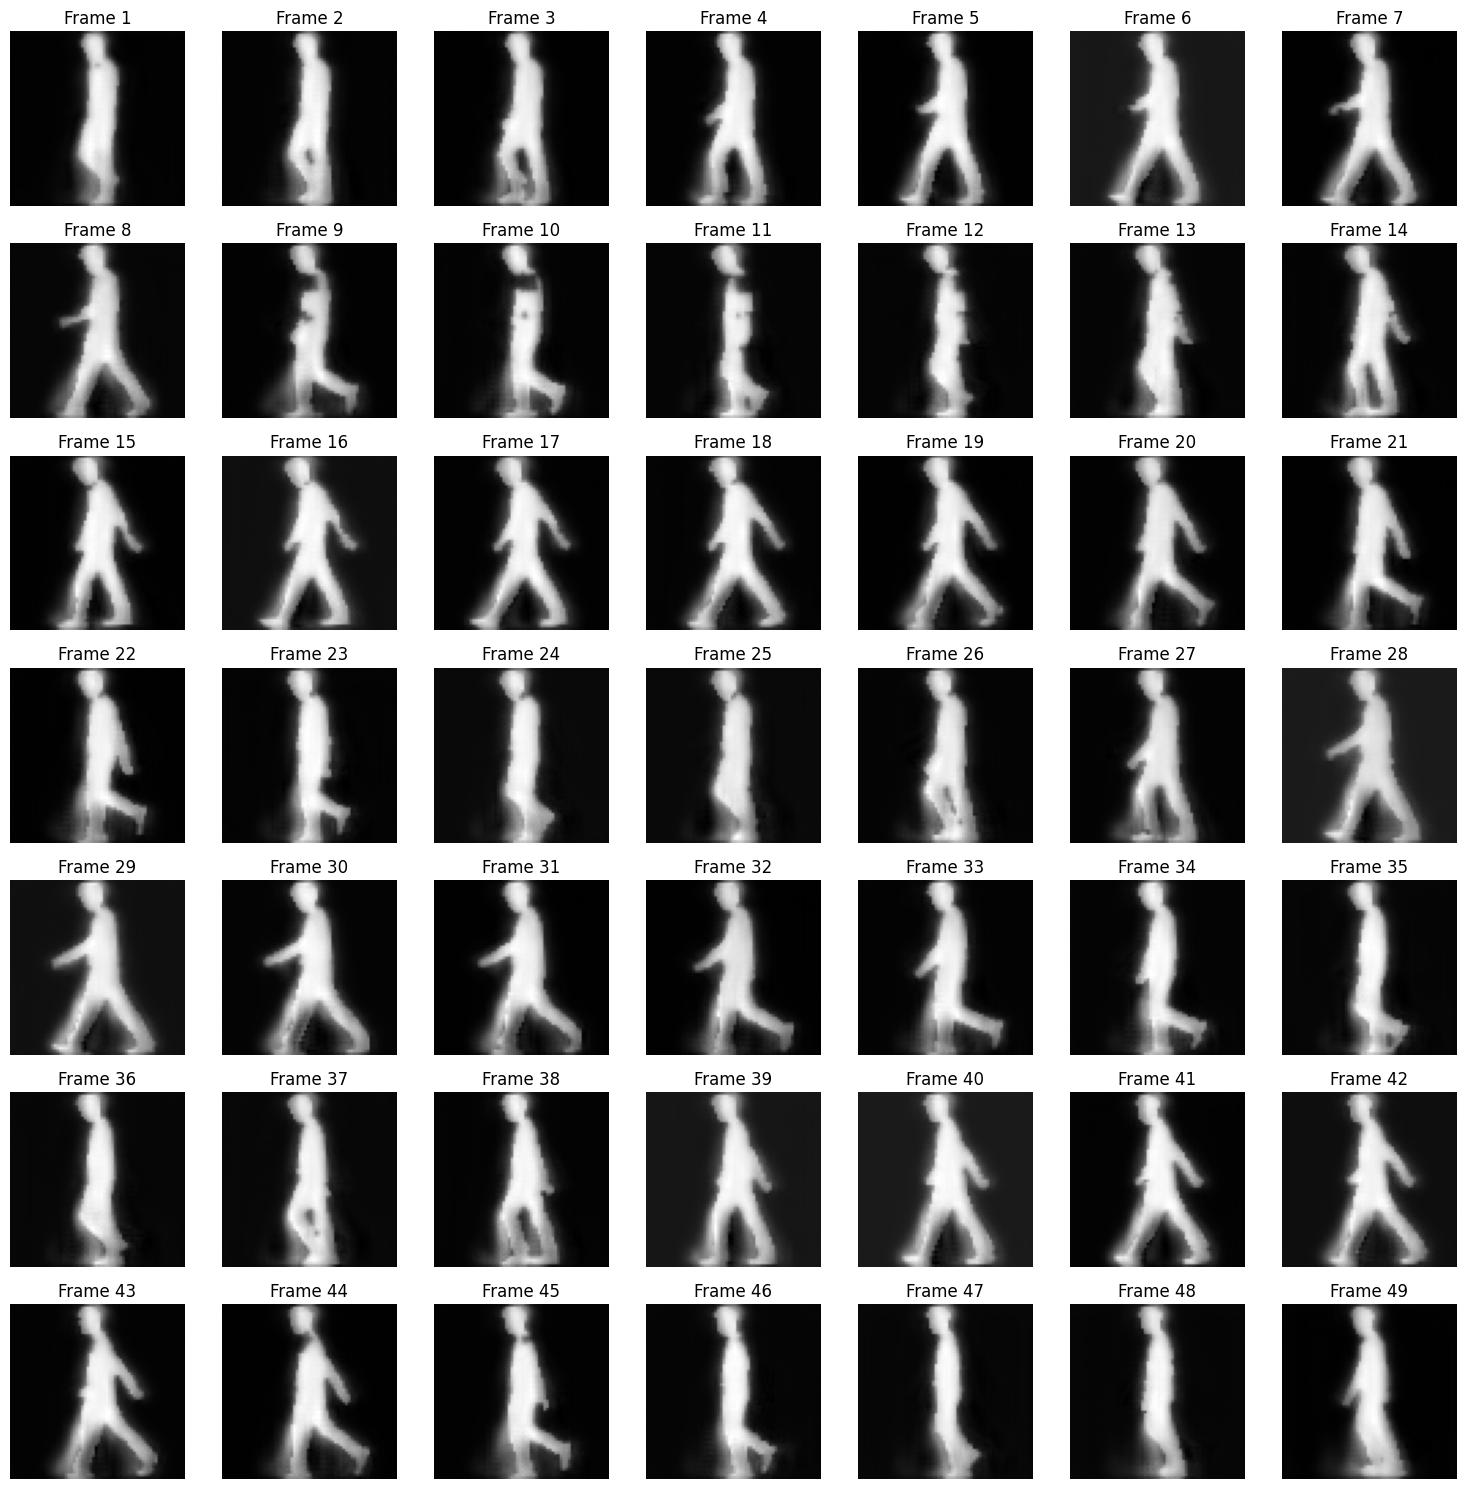

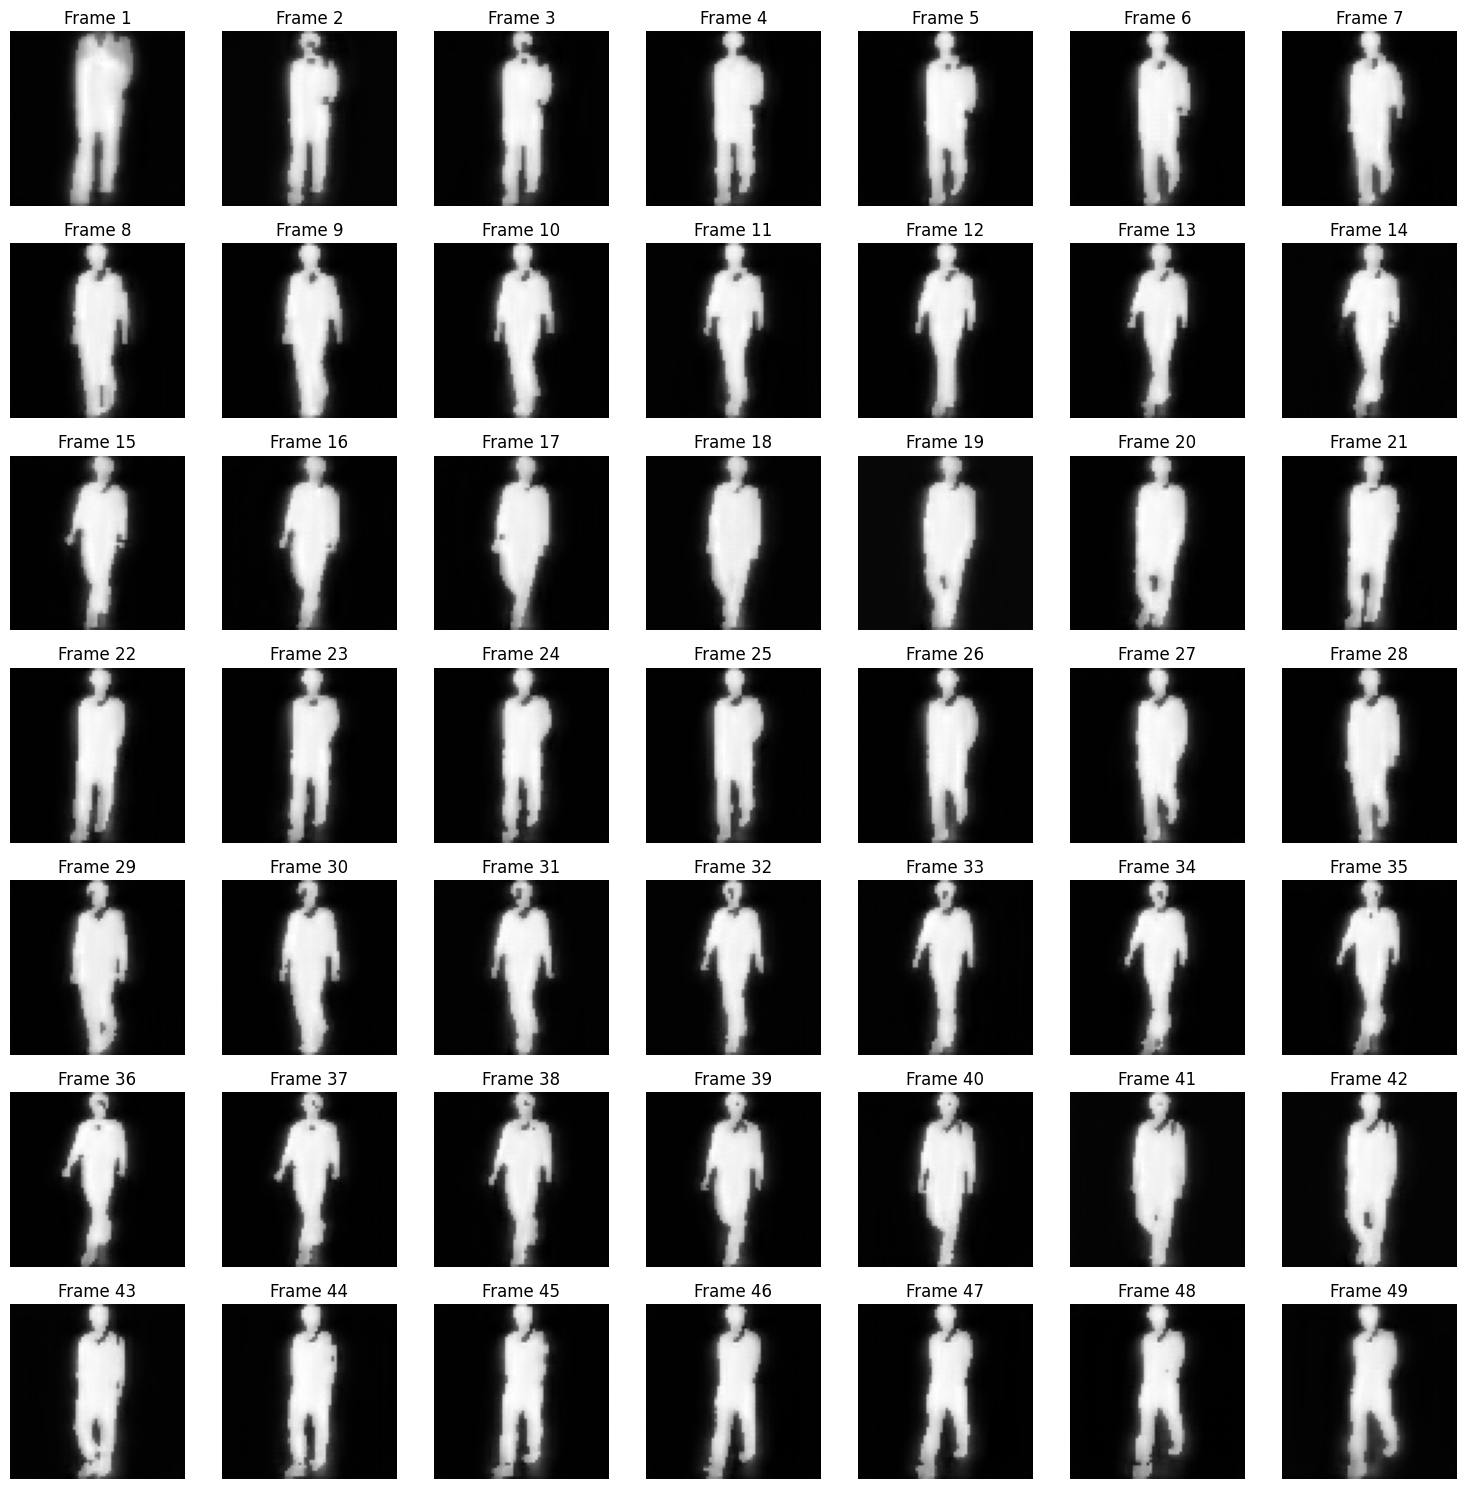

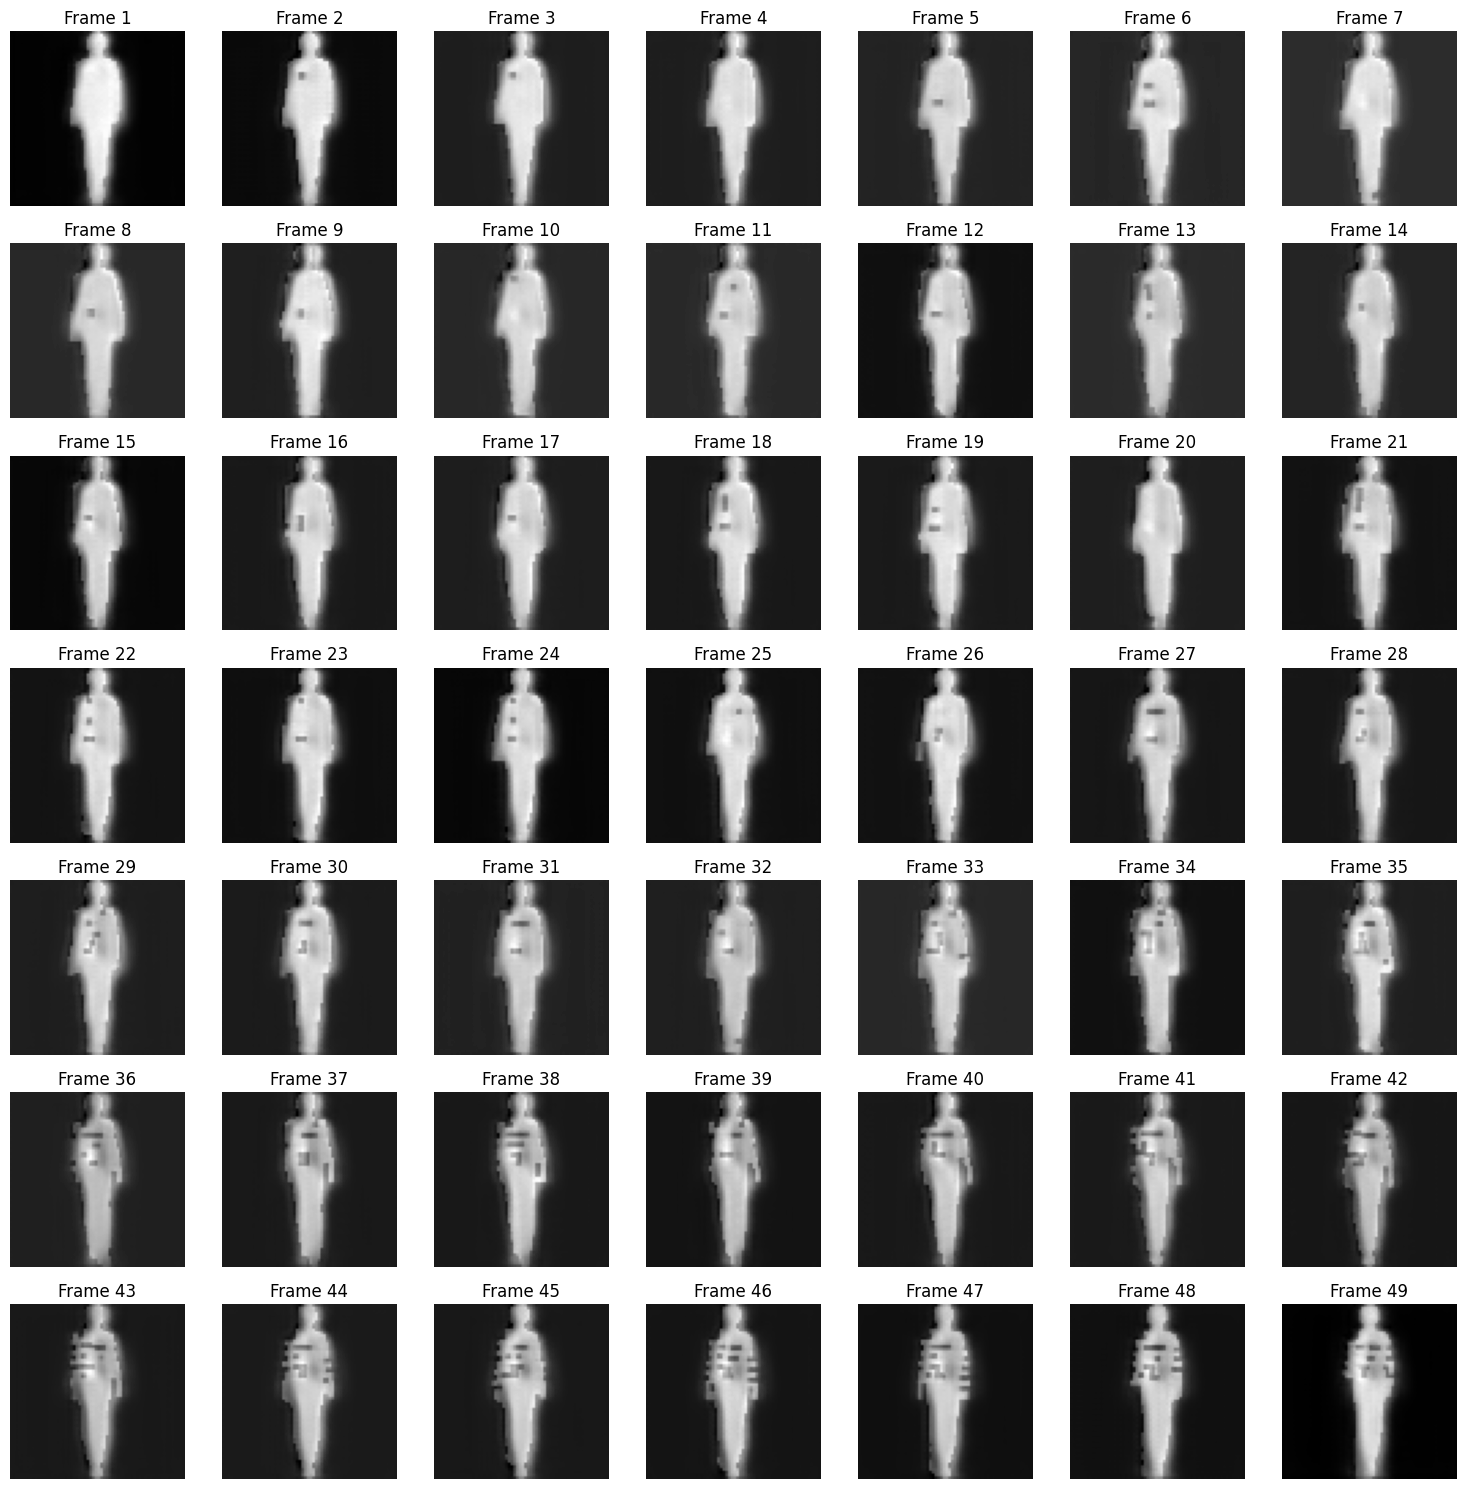

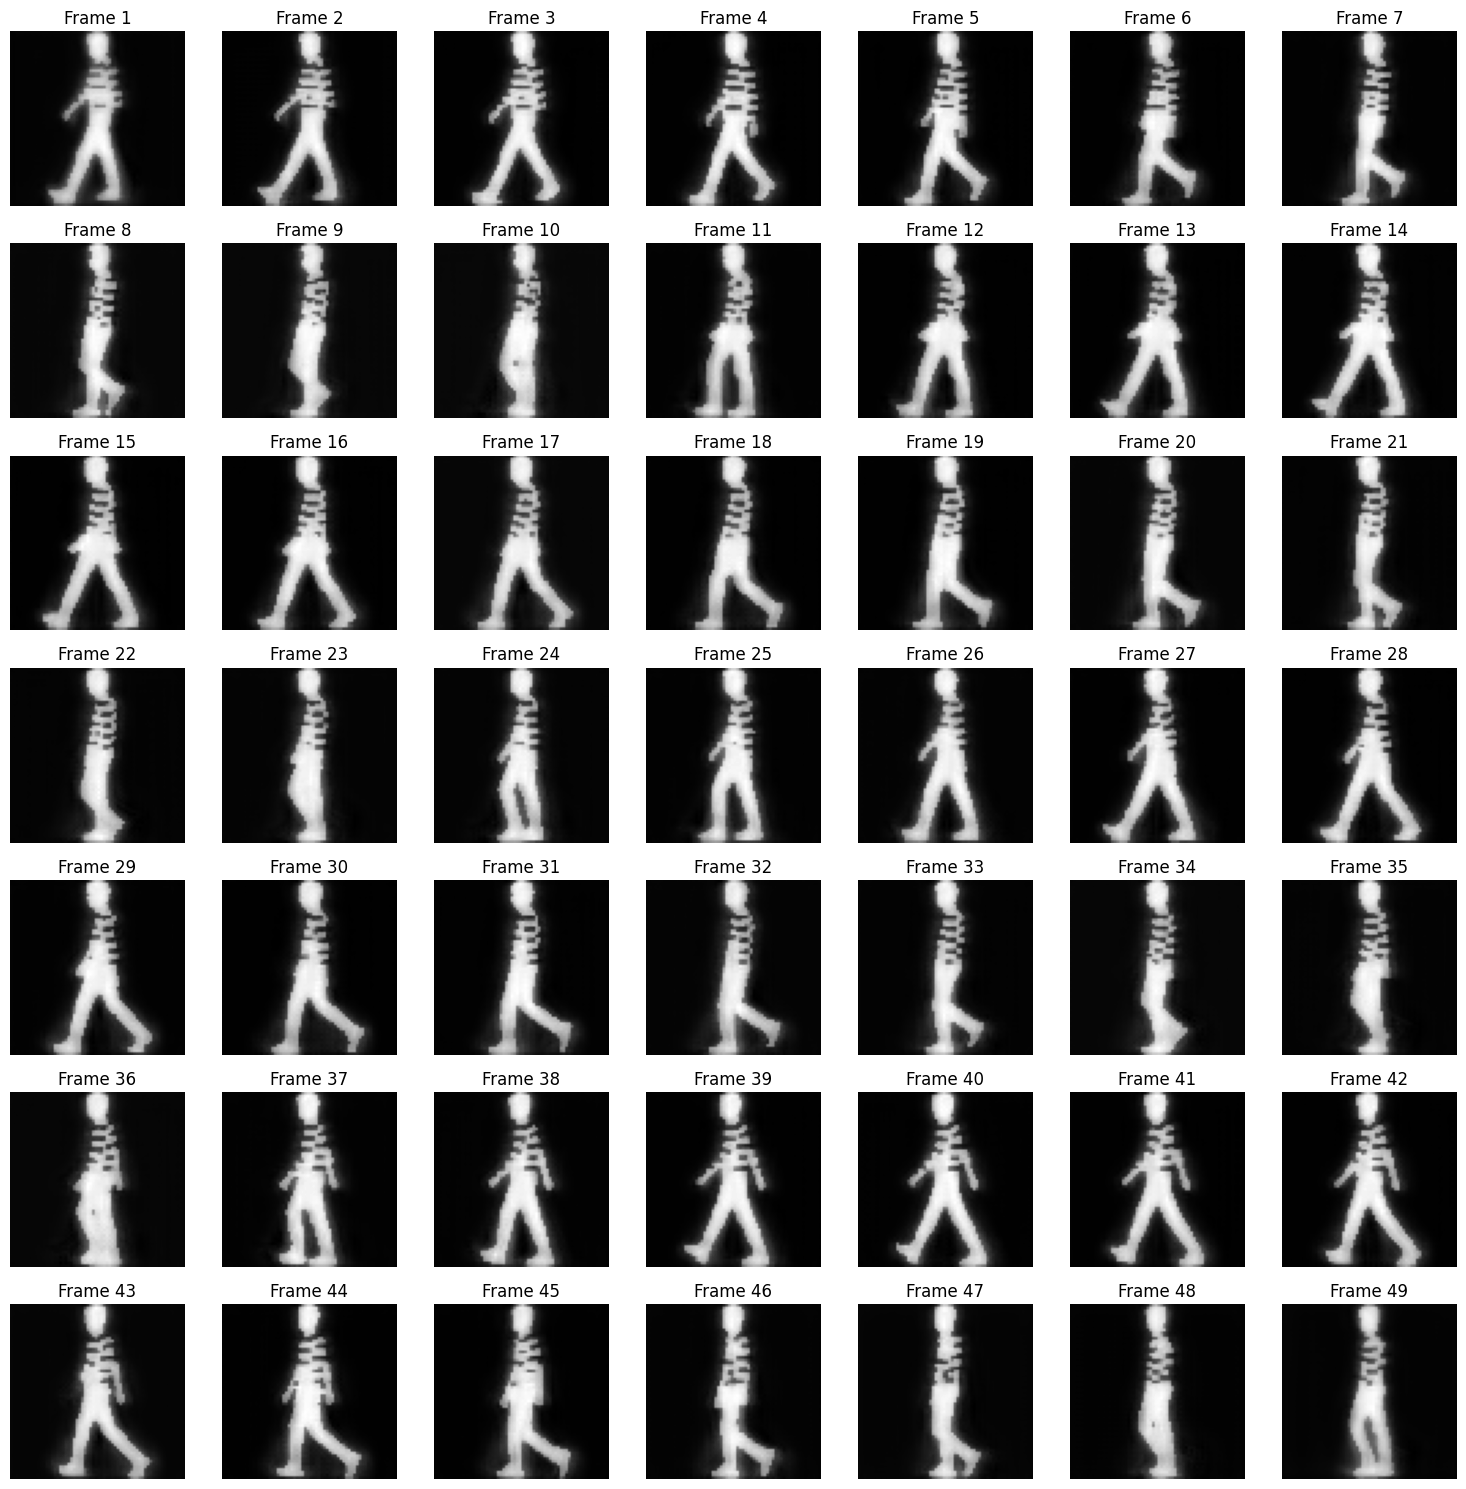

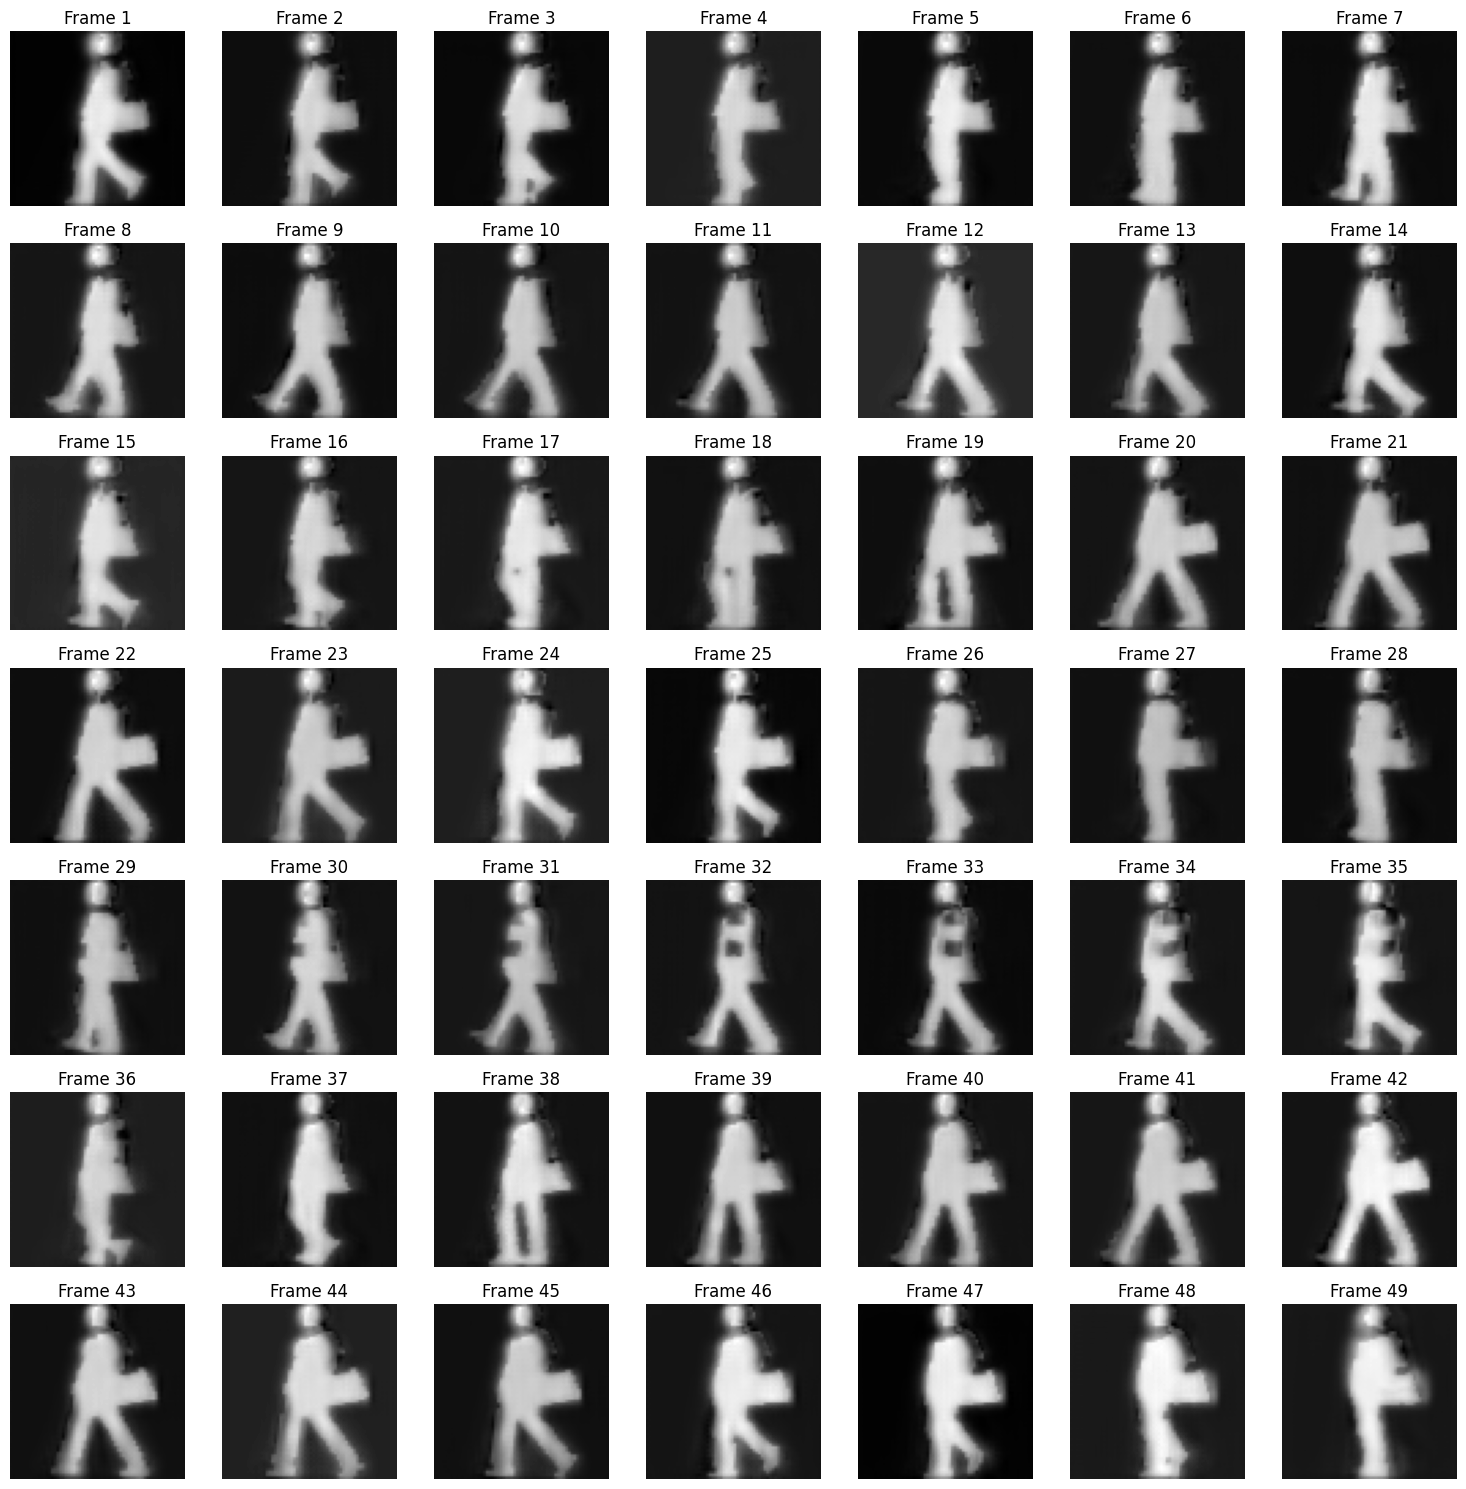

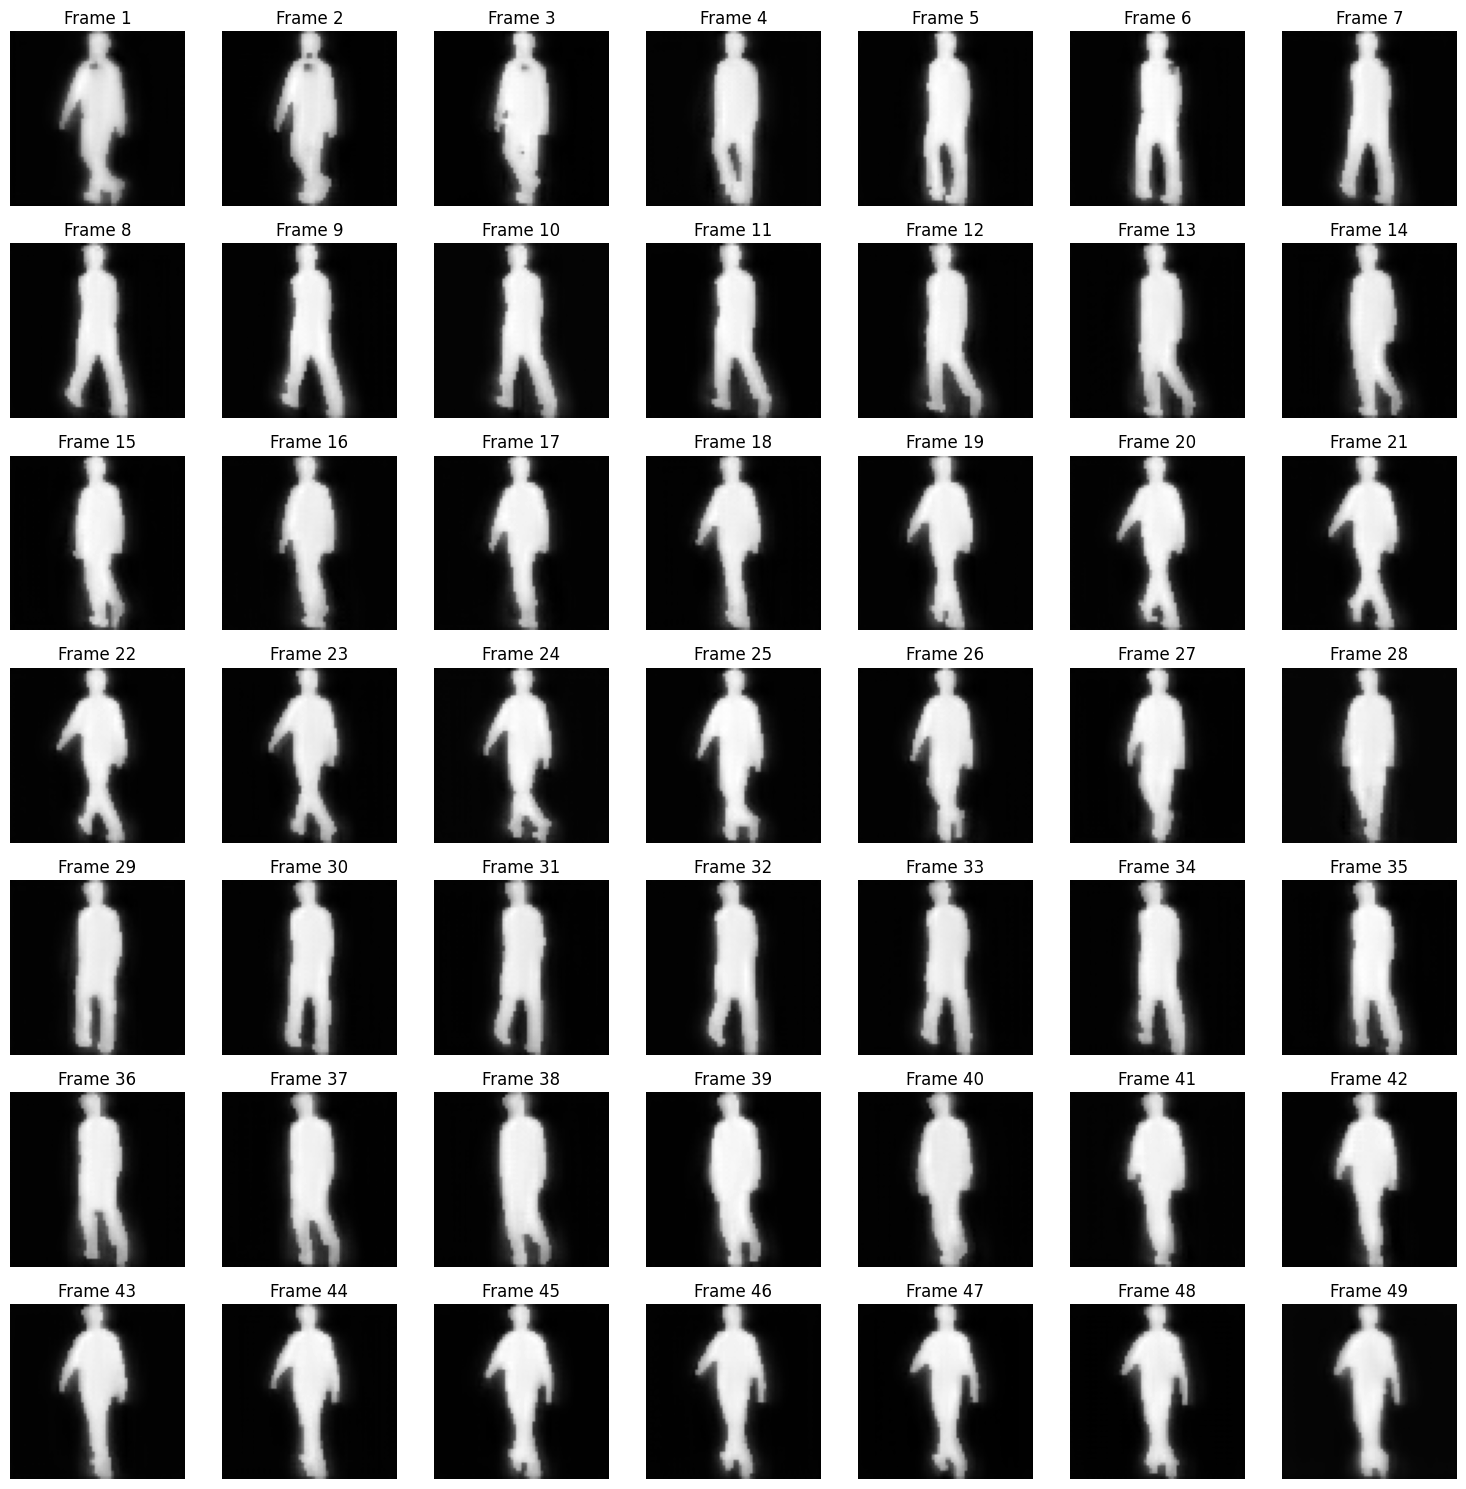

KeyboardInterrupt: 

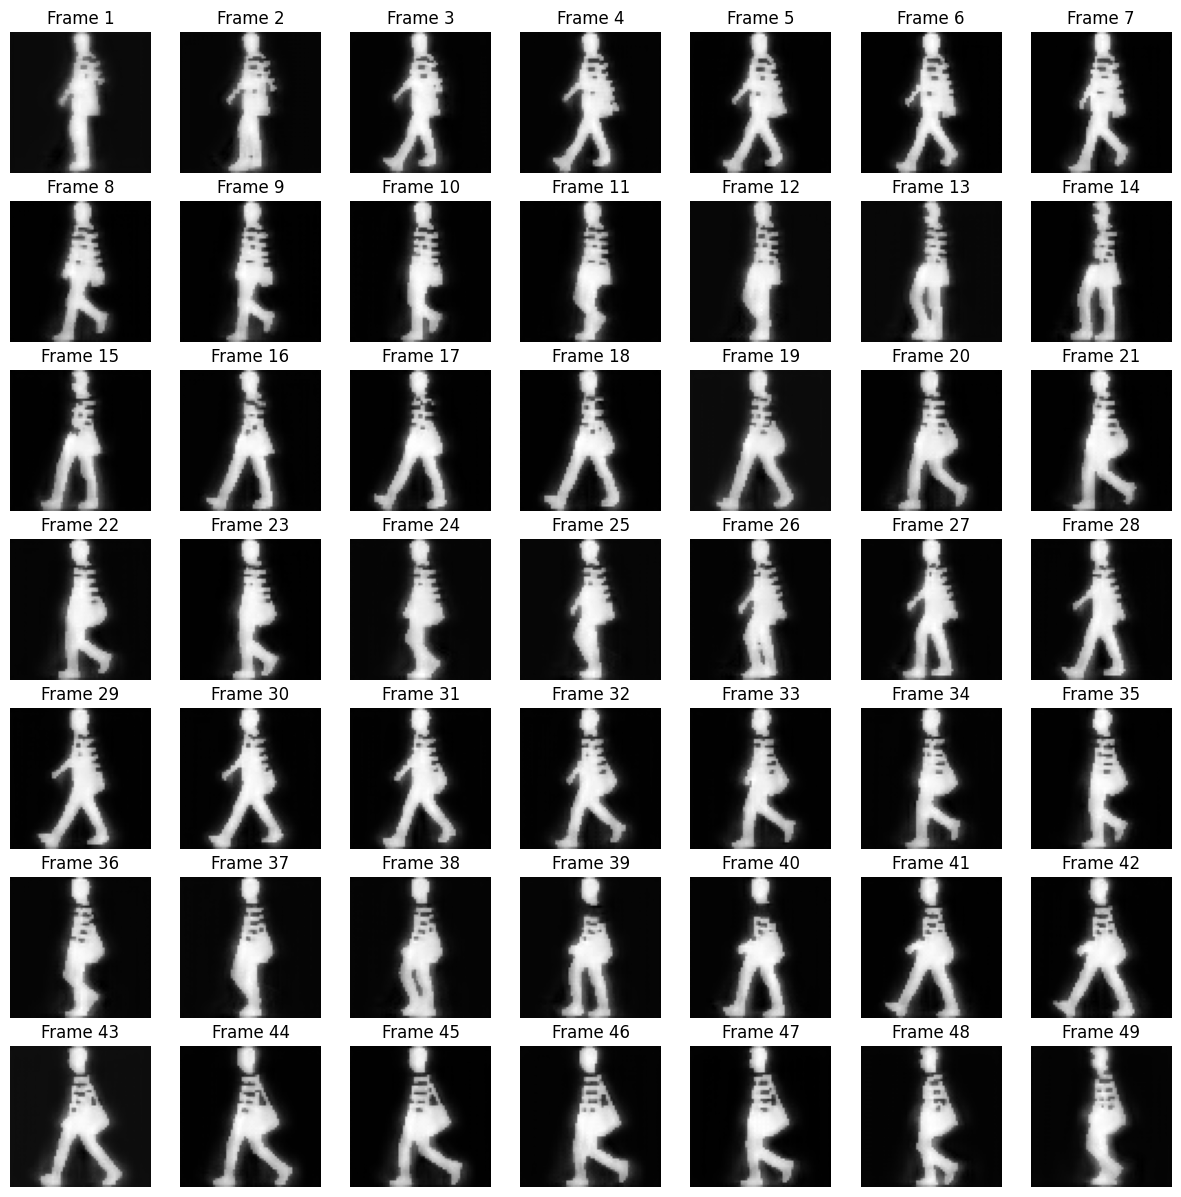

In [25]:
# Train the whole network over here...( with mse loss )

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Check if a GPU is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Define the frame embedding layer
class FrameEmbedding(nn.Module):
    def __init__(self, frame_dim, embedding_dim):
        super(FrameEmbedding, self).__init__()
        self.linear = nn.Linear(frame_dim, embedding_dim)

    def forward(self, x):
        return self.linear(x)

# Define positional encoding (sinusoidal)
class PositionalEncoding(nn.Module):
    def __init__(self, embedding_dim, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, embedding_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2).float() * (-math.log(10000.0) / embedding_dim))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0).transpose(0, 1)

    def forward(self, x):
        seq_len = x.size(0)
        return self.encoding[:seq_len, :]

# Define the 3D convolutional block
class ConvBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock3D, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x

class EncoderBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock3D, self).__init__()
        self.conv_block = ConvBlock3D(in_channels, out_channels)
        self.downsample = nn.Conv3d(out_channels, out_channels, kernel_size=(1, 2, 2), stride=2)

    def forward(self, x):
        x = self.conv_block(x)
        x_pooled = self.downsample(x)
        return x, x_pooled

    

class DecoderBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock3D, self).__init__()
        self.conv_block = ConvBlock3D(in_channels, out_channels)
        self.upsample = nn.ConvTranspose3d(out_channels, out_channels, kernel_size=(1, 2, 2), stride=2)

    def forward(self, x, skip_connection):
        x = self.conv_block(x)
        x = self.upsample(x)
        x = torch.cat([x, skip_connection], dim=1)
        return x
    
# Define the U-Net model with global average pooling
class UNet3D(nn.Module):
    def __init__(self, embedding_dim=128, frame_dim=64):
        super(UNet3D, self).__init__()
        self.encoder1 = EncoderBlock3D(1, 64)
        self.encoder2 = EncoderBlock3D(64, 128)
        self.encoder3 = EncoderBlock3D(128, 256)
        self.encoder4 = EncoderBlock3D(256, 512)
        self.global_avg_pool = nn.AdaptiveAvgPool3d(1)
        
        self.decoder1 = DecoderBlock3D(512, 256)
        self.decoder2 = DecoderBlock3D(512, 128)
        self.decoder3 = DecoderBlock3D(256, 64)
        self.final_conv = nn.Conv3d(128, 1, kernel_size=3, padding=1)  # Final convolution to get the desired shape
        
    def forward(self, x, frame_indices, encoder_only):
        e1, e1_pooled = self.encoder1(x)
        e2, e2_pooled = self.encoder2(e1_pooled)
        e3, e3_pooled = self.encoder3(e2_pooled)
        e4, e4_pooled = self.encoder4(e3_pooled)

        embedding = self.global_avg_pool(e4_pooled)
        embedding_ = embedding.view(embedding.size(0), -1)

        if not encoder_only:         
            d1 = self.decoder1(e4, e3)
            d2 = self.decoder2(d1, e2)
            e1 = e1[:, :, :49, :, :]  # Trimming e1 to match the frame size
            d3 = self.decoder3(d2, e1)
            out = self.final_conv(d3)  # Reducing channels to 1
            return out

        return embedding_
    

class TripletLoss(nn.Module):
    def __init__(self, margin, loss_term_weight=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.loss_term_weight = loss_term_weight

    def forward(self, embeddings, labels):
        embeddings = embeddings.squeeze(1)
        n = embeddings.size(0)

        dist_matrix = self._pairwise_distances(embeddings)
        triplets = self._get_triplets(dist_matrix, labels)

        if triplets is None:
            return torch.tensor(0.0).to(embeddings.device), {}

        ap_dist = dist_matrix[triplets[:, 0], triplets[:, 1]]
        an_dist = dist_matrix[triplets[:, 0], triplets[:, 2]]
        triplet_loss = F.relu(ap_dist - an_dist + self.margin)

        loss = triplet_loss.mean() * self.loss_term_weight
        info = {'loss': loss.item(), 'num_triplets': triplets.size(0)}

        return loss, info

    def _pairwise_distances(self, embeddings):
        dot_product = torch.matmul(embeddings, embeddings.t())
        square_sum = torch.diagonal(dot_product)
        dist_matrix = square_sum.unsqueeze(0) - 2 * dot_product + square_sum.unsqueeze(1)
        dist_matrix = torch.sqrt(F.relu(dist_matrix))
        return dist_matrix

    def _get_triplets(self, dist_matrix, labels):
        labels = labels.cpu().numpy()
        triplets = []

        for i in range(labels.shape[0]):
            for j in range(labels.shape[0]):
                if labels[i] == labels[j] and i != j:
                    for k in range(labels.shape[0]):
                        if labels[i] != labels[k]:
                            triplets.append([i, j, k])

        if len(triplets) == 0:
            return None

        return torch.tensor(triplets).to(dist_matrix.device)

class CrossEntropyLoss(nn.Module):
    def __init__(self, scale=16, label_smooth=True, eps=0.1, loss_term_weight=1.0, log_accuracy=False):
        super(CrossEntropyLoss, self).__init__()
        self.scale = scale
        self.label_smooth = label_smooth
        self.eps = eps
        self.loss_term_weight = loss_term_weight
        self.log_accuracy = log_accuracy

    def forward(self, logits, labels):
        logits = logits.squeeze(1)
        labels = labels.long()

        if self.label_smooth:
            loss = F.cross_entropy(logits * self.scale, labels, label_smoothing=self.eps)
        else:
            loss = F.cross_entropy(logits * self.scale, labels)

        info = {'loss': loss.item()}

        if self.log_accuracy:
            preds = logits.argmax(dim=1)
            accuracy = (preds == labels).float().mean().item()
            info['accuracy'] = accuracy

        return loss * self.loss_term_weight, info


# Training loop
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

def print_image_from_tensor(tensor, grid_size=(7, 7)):
    # Assuming tensor shape is [1, 1, 49, 16, 16]
    tensor = tensor.detach().squeeze().cpu().numpy()  # Remove single-dimensional entries from the shape of an array

    num_frames = tensor.shape[0]
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(15, 15))
    
    for i in range(num_frames):
        row = i // grid_size[1]
        col = i % grid_size[1]
        axes[row, col].imshow(tensor[i], cmap='gray')  # Assuming grayscale image
        axes[row, col].axis('off')  # Hide axis
        axes[row, col].set_title(f'Frame {i+1}')

    # Hide any unused subplots
    for j in range(num_frames, grid_size[0] * grid_size[1]):
        row = j // grid_size[1]
        col = j % grid_size[1]
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()
# Assuming your tensor is named 'image_tensor'
padding = (10,10)
model = UNet3D().to(device)

# Load the weights
checkpoint_path = '/kaggle/working/FullyTrainedModel.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

# model has the pre-trained weights and is ready for training or evaluation

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 10

for epoch in range(num_epochs):
    total_loss = 0.0

    for each_batch in loader:
        optimizer.zero_grad()
        ipts, labs, typs, vies, seqL = inputs_pretreament(each_batch)
        ipts_truth, labs_truth, typs_truth, vies_truth, seqL_truth = inputs_pretreament_without_mask(each_batch)
        
        ipts[0] = F.pad(ipts[0], padding)
        ipts[0] = ipts[0].unsqueeze(1)
        batch_size , channels , num_frames, height, width = ipts[0].shape
        ipts = ipts[0].to(device)
        labs = labs.to(device)
        
        ipts_truth[0] = F.pad(ipts_truth[0],padding)
        ipts_truth[0] = ipts_truth[0].unsqueeze(1)
        batch_size , channels , num_frames, height, width = ipts_truth[0].shape
        ipts_truth = ipts_truth[0].to(device)
        labs_truth = labs_truth.to(device)
        
        each_video_loss = 0.0
        for i in range(ipts.size(0)):
            slice_tensor_padded = ipts[i].unsqueeze(0)
            slice_truth_padded =  ipts_truth[i].unsqueeze(0)
            frame_indices = torch.arange(8).float().to(device)
            
            model_predicted_embedding = model(slice_tensor_padded, frame_indices, False)
            slice_tensor_padded = slice_tensor_padded[:, :, :49, :, :]
            slice_truth_padded = slice_truth_padded[:,:, :49, :, :]
            
            print_image_from_tensor(model_predicted_embedding)
            each_video_loss += F.mse_loss(model_predicted_embedding,slice_truth_padded)

        each_video_loss.backward()
        optimizer.step()
#         print("MSE loss for a batch --> ", each_video_loss.item())
        total_loss += each_video_loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(loader)}')
            
        
        


In [ ]:
# Training the Classification head over here...
class ClassificationHead(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ClassificationHead, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

model = UNet3D().to(device)
embedding_dim = 512
num_classes = 74
classification_head = ClassificationHead(input_dim=embedding_dim, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(model.parameters()) + list(classification_head.parameters()), lr=1e-4)
padding = (10,10)
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    classification_head.train()
    total_loss = 0.0
    for each_batch in loader:
        optimizer.zero_grad()
        ipts, labs, typs, vies, seqL = inputs_pretreament(each_batch)
        
        ipts[0] = F.pad(ipts[0], padding)
        ipts[0] = ipts[0].unsqueeze(1)
        ipts = ipts[0].to(device)
        labs = labs.to(device)
        
        batch_embeddings = torch.zeros((0, model(ipts[0].unsqueeze(0).to(device), torch.arange(8).float().to(device), True).shape[1]), device=device)
        batch_labels = torch.zeros(0, dtype=torch.long, device=device)
        for i in range(ipts.size(0)):
            slice_tensor_padded = ipts[i].unsqueeze(0)
            frame_indices = torch.arange(8).float().to(device)

            model_predicted_embedding = model(slice_tensor_padded, frame_indices, True)
            batch_embeddings = torch.cat((batch_embeddings, model_predicted_embedding), dim=0)
            batch_labels = torch.cat((batch_labels, labs[i].unsqueeze(0)), dim=0)
        
        
#         embeddings = model(ipts, frame_indices=None, encoder_only=True)
#         print("The shape of the batch_embeddings --> ", batch_embeddings.shape)
        logits = classification_head(batch_embeddings)
        
        loss = criterion(logits, labs)
        loss.backward()
        optimizer.step()
        print("the Batch loss --> ", loss.item())
        total_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(loader)}')
